num neighbors: 2
total metastates: 64
[001] Rule ID = 43032100132210100332220103003331311233222112121013231030113321021


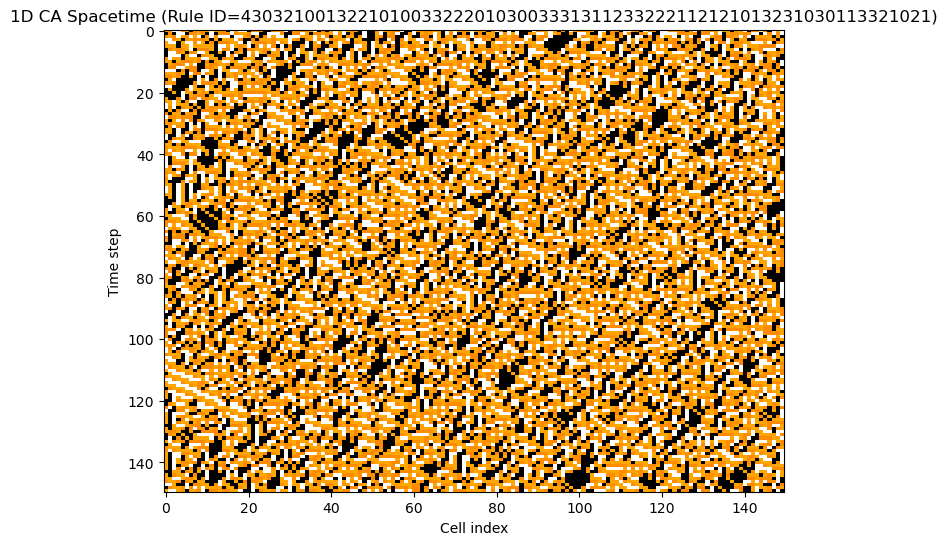

num neighbors: 2
total metastates: 64
[002] Rule ID = 43302030221001233222302203323001011212230322030313122110013010301


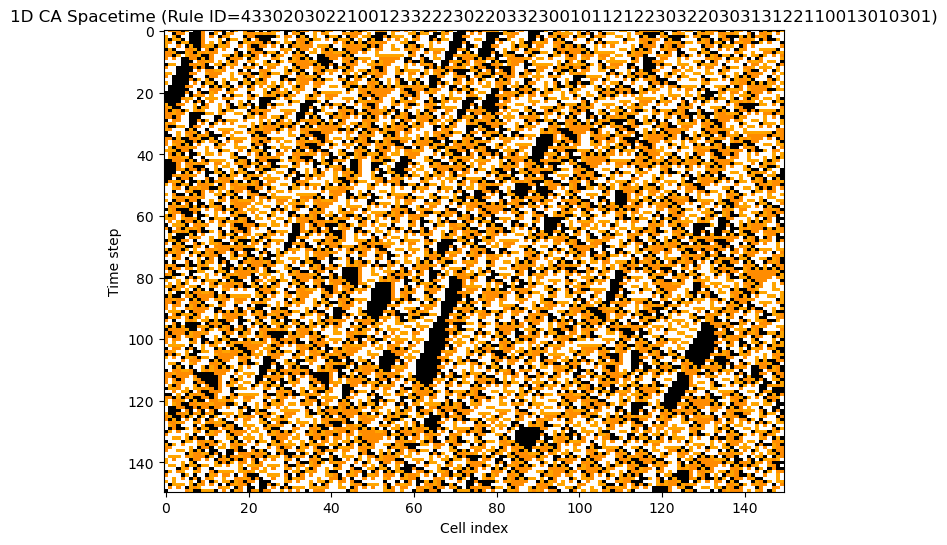

num neighbors: 2
total metastates: 64
[003] Rule ID = 41203302021002003121311313102102112213202313211123020233002131201


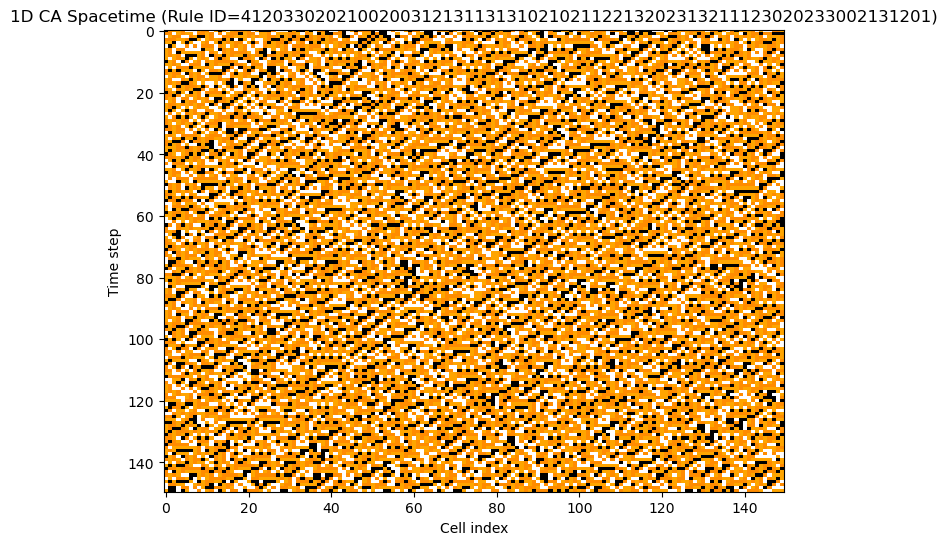

num neighbors: 2
total metastates: 64
[004] Rule ID = 43333000220023323132023223013332330002003110121210220120002113213


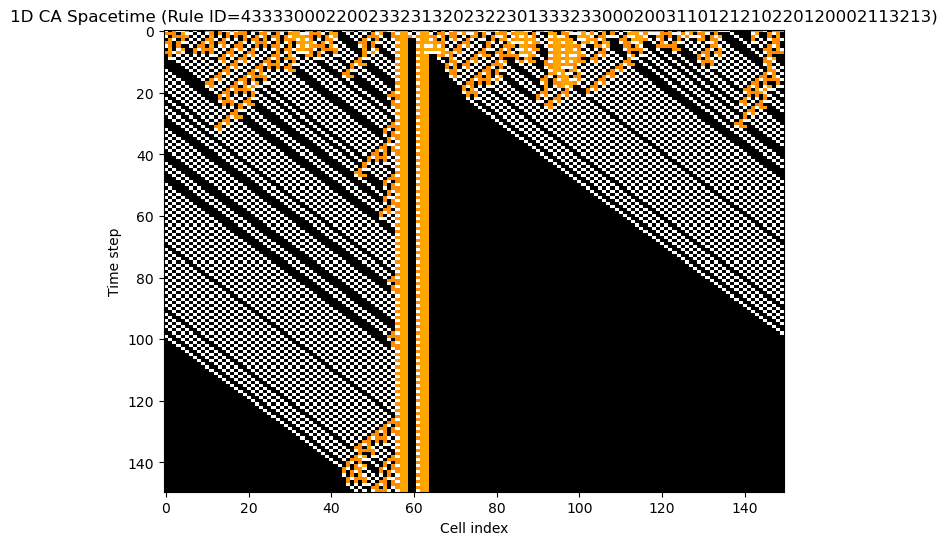

num neighbors: 2
total metastates: 64
[005] Rule ID = 41211022003011200033322031322202312210003012131311220221232232010


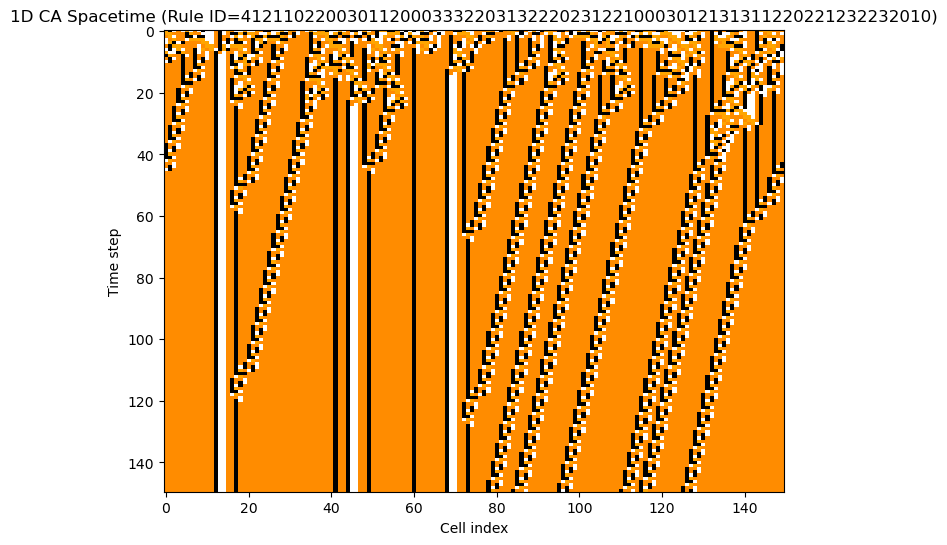

num neighbors: 2
total metastates: 64
[006] Rule ID = 41111122300200131031322031311313323002000202200013321103211121013


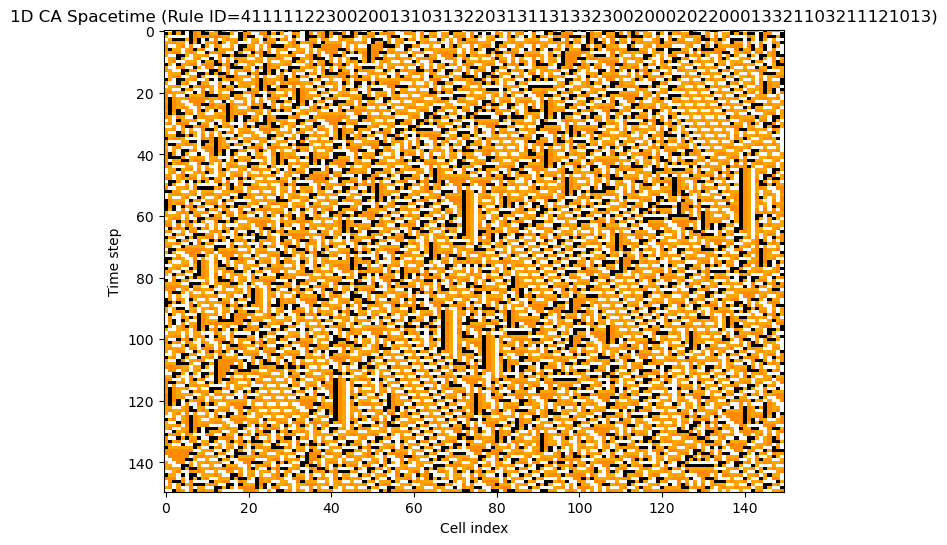

num neighbors: 2
total metastates: 64
[007] Rule ID = 42010112122311323133300022101321002200331303100120032012332213102


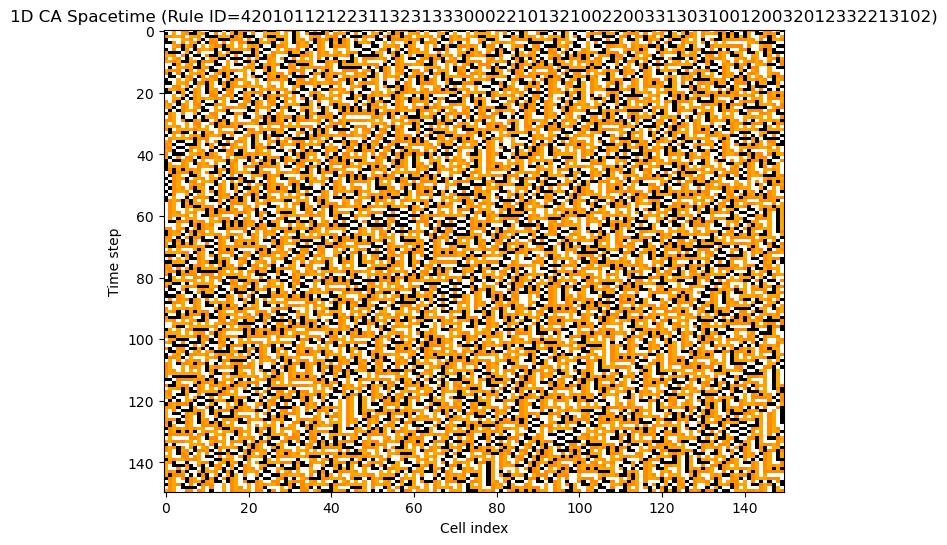

num neighbors: 2
total metastates: 64
[008] Rule ID = 42130221301310233303203310111100102132221001300222002031232223100


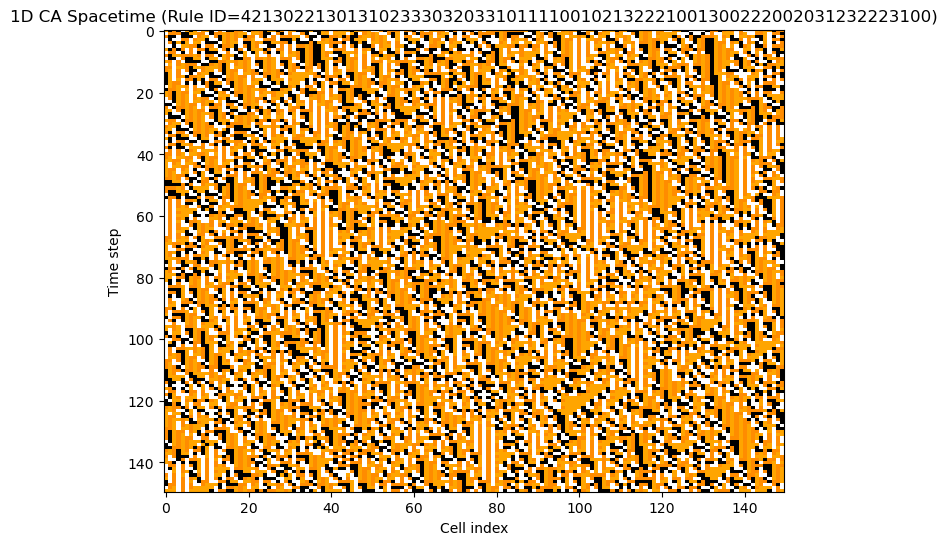

num neighbors: 2
total metastates: 64
[009] Rule ID = 43222321303222132020022002020313131222033223130031221022322333322


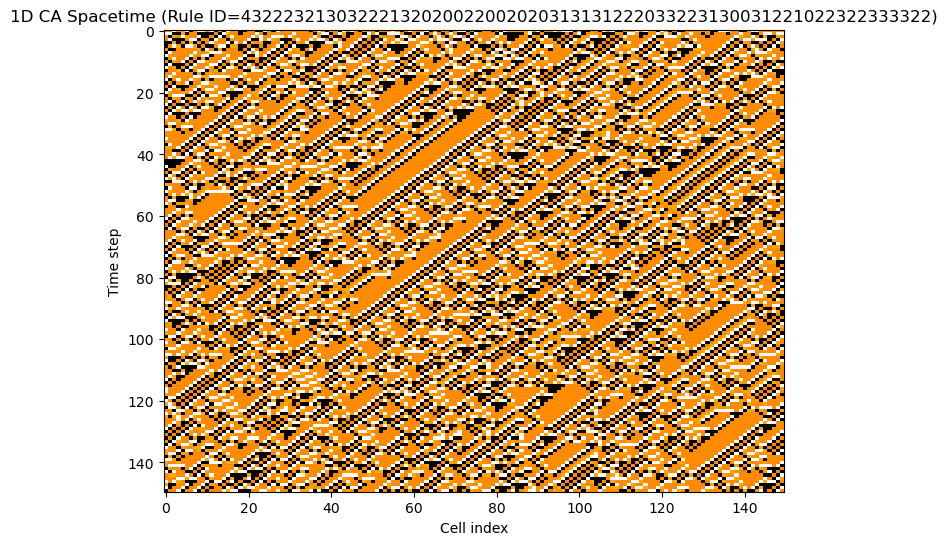

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from itertools import product

class CellularAutomatonRules:
    """
    Encapsulates creation, validation, execution, and visualization of cellular automata rules,
    supporting both directional (ordered neighbor states) and non-directional (unordered neighbor counts) metastate logic.
    Also supports loading 1D elementary CA via Wolfram codes and a generalized base-n rule ID scheme.
    """
    def __init__(self, num_states, stochastic=False, dim=2, directional=False, rule_id=None):
        self.num_states = num_states
        self.stochastic = stochastic
        self.dim = dim
        self.directional = directional
        self.num_neighbors = 3**dim - 1
        self.num_metastates = self._compute_num_metastates()
        self.rule_id = None

        print(f"num neighbors: {self.num_neighbors}")
        print(f"total metastates: {self.num_metastates}")

        # prepare empty rules matrix
        self.rules_matrix = np.zeros((self.num_metastates, self.num_states - 1), dtype=int)

        # fill matrix
        if self.stochastic:
            self._create_stochastic_matrix()
        else:
            # deterministic: generate or load rule_id, then populate
            self.rule_id = rule_id or self._random_rule_id()
            self.load_rule_id(self.rule_id)

        if not self.check_rules_matrix():
            raise ValueError("Rules matrix validation failed: some rows sum > 1.")

    def _compute_num_metastates(self):
        if self.directional:
            return self.num_states ** (self.num_neighbors + 1)
        return self.num_states * math.comb(self.num_neighbors + self.num_states - 1,
                                           self.num_states - 1)

    def _create_stochastic_matrix(self):
        for i in range(self.num_metastates):
            remaining = 1.0
            for j in range(self.num_states - 1):
                val = np.random.uniform(0, remaining)
                self.rules_matrix[i, j] = val
                remaining -= val

    def check_rules_matrix(self):
        row_sums = np.sum(self.rules_matrix, axis=1)
        invalid = np.where(row_sums > 1)[0]
        if invalid.size > 0:
            for idx in invalid:
                print(f"Metastate {idx} sum > 1: {row_sums[idx]}")
            return False
        return True

    def _random_rule_id(self):
        digits = []
        for _ in range(self.num_metastates):
            digit = np.random.randint(0, self.num_states)
            digits.append(self._digit_to_char(digit))
        return str(self.num_states) + ''.join(digits)

    def set_wolfram_rule(self, rule_code):
        if not (self.dim == 1 and self.num_states == 2 and self.directional):
            raise ValueError("Wolfram codes only supported for 1D, 2-state, directional CA.")
        if not (0 <= rule_code < 2**self.num_metastates):
            raise ValueError(f"Rule code must be in [0,{2**self.num_metastates - 1}].")
        bits = np.binary_repr(rule_code, width=self.num_metastates)
        self.rule_id = str(self.num_states) + ''.join(bits)
        self.load_rule_id(self.rule_id)

    def encode_rule_id(self):
        if self.stochastic:
            raise ValueError("Cannot encode rule ID for stochastic rules.")
        digits = []
        for row in self.rules_matrix:
            ones = np.where(row == 1)[0]
            if ones.size > 0:
                next_state = int(ones[0])
            else:
                next_state = self.num_states - 1
            digits.append(self._digit_to_char(next_state))
        return str(self.num_states) + ''.join(digits)

    def load_rule_id(self, rule_id):
        prefix = str(self.num_states)
        if not rule_id.startswith(prefix):
            raise ValueError("Rule ID num_states mismatch.")
        code = rule_id[len(prefix):]
        if len(code) != self.num_metastates:
            raise ValueError("Rule ID length does not match metastates.")
        self.rules_matrix.fill(0)
        for i, ch in enumerate(code):
            digit = self._char_to_digit(ch)
            if digit < self.num_states - 1:
                self.rules_matrix[i, digit] = 1
        self.rule_id = rule_id

    @staticmethod
    def _digit_to_char(d):
        if d < 10:
            return str(d)
        return chr(ord('A') + d - 10)

    @staticmethod
    def _char_to_digit(ch):
        if ch.isdigit():
            return int(ch)
        return ord(ch) - ord('A') + 10

    def _compute_metastate_index(self, neighborhood):
        idx = 0
        for s in neighborhood:
            idx = idx * self.num_states + s
        return idx

    def _directional_metastate_tuples(self):
        return sorted(
            product(range(self.num_states), repeat=self.num_neighbors + 1),
            reverse=True
        )

    def run_1d(self, width, time_steps, init=None, periodic=True, init_mode='random', init_state=1):
        """
        Simulate a 1D CA.
        init: optional array of length width.
        init_mode: 'random', 'single', or 'uniform'.
        init_state: state for 'single' or 'uniform'.
        """
        if self.dim != 1:
            raise ValueError("run_1d requires dim=1.")
        ca = np.zeros((time_steps, width), dtype=int)
        # initialize
        if init is not None:
            if len(init) != width:
                raise ValueError("Initial condition length mismatch.")
            ca[0] = init
        else:
            if init_mode == 'random':
                ca[0] = np.random.randint(0, self.num_states, size=width)
            elif init_mode == 'single':
                ca[0] = np.zeros(width, dtype=int)
                ca[0][width//2] = init_state
            elif init_mode == 'uniform':
                ca[0].fill(init_state)
            else:
                raise ValueError(f"Unknown init_mode: {init_mode}")
        # simulation
        if self.directional:
            tuples = self._directional_metastate_tuples()
            neigh_to_idx = {tpl: i for i, tpl in enumerate(tuples)}
            for t in range(1, time_steps):
                prev = ca[t-1]
                next_row = np.zeros(width, dtype=int)
                for i in range(width):
                    left = prev[(i-1)%width] if periodic else (prev[i-1] if i>0 else 0)
                    center = prev[i]
                    right = prev[(i+1)%width] if periodic else (prev[i+1] if i<width-1 else 0)
                    idx = neigh_to_idx[(left, center, right)]
                    row = self.rules_matrix[idx]
                    probs = np.append(row, 1-np.sum(row))
                    next_row[i] = (np.random.choice(self.num_states, p=probs)
                                   if self.stochastic else int(np.argmax(probs)))
                ca[t] = next_row
        else:
            for t in range(1, time_steps):
                prev = ca[t-1]
                next_row = np.zeros(width, dtype=int)
                for i in range(width):
                    left = prev[(i-1)%width] if periodic else (prev[i-1] if i>0 else 0)
                    center = prev[i]
                    right = prev[(i+1)%width] if periodic else (prev[i+1] if i<width-1 else 0)
                    idx = left*(self.num_states**2) + center*self.num_states + right
                    row = self.rules_matrix[idx]
                    probs = np.append(row, 1-np.sum(row))
                    next_row[i] = (np.random.choice(self.num_states, p=probs)
                                   if self.stochastic else int(np.argmax(probs)))
                ca[t] = next_row
        return ca

    def plot_1d_spacetime(self, ca_array, cmap=None):
        """
        Display the 1D CA spacetime, using white(0), yellow(1), brown(2) by default.
        """
        cmap = cmap or mcolors.ListedColormap(['saddlebrown','white','yellow'])
        plt.figure(figsize=(8, 6))
        plt.imshow(ca_array,
                   aspect='auto',
                   cmap=cmap,
                   interpolation='nearest')
        plt.xlabel('Cell index')
        plt.ylabel('Time step')
        plt.title(f'1D CA Spacetime (Rule ID={self.rule_id})')
        plt.show()

if __name__ == "__main__":
    # run 100 random deterministic 3‑state CAs
    for i in range(1, 10):
        ca = CellularAutomatonRules(
            num_states=4,
            stochastic=False,
            dim=1,
            directional=True
        )
        # rule_id was chosen at random inside __init__
        sim = ca.run_1d(
            width=150,
            time_steps=150,
            init_mode='random'
        )
        print(f"[{i:03d}] Rule ID = {ca.rule_id}")
        ca.plot_1d_spacetime(sim, cmap=mcolors.ListedColormap(['white', 'orange', 'darkorange' ,'black']))


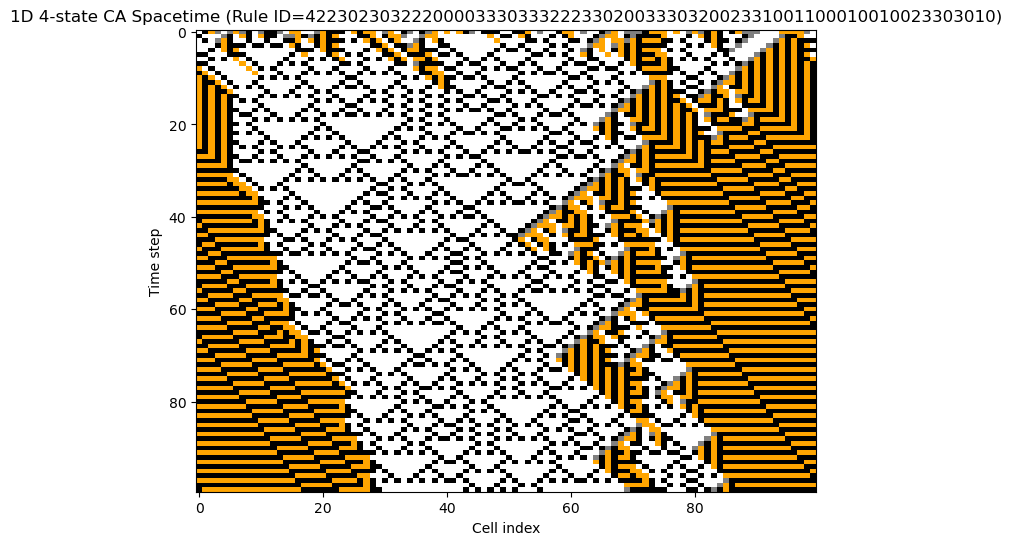

In [94]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from itertools import product

class CellularAutomatonRules:
    """
    Creates, validates, executes, and visualizes 1D directional cellular automata
    with an explicit rule_id for a 4-state system.
    """
    def __init__(self, num_states, rule_id, stochastic=False, dim=1, directional=True):
        self.num_states   = num_states
        self.stochastic   = stochastic
        self.dim          = dim
        self.directional  = directional
        self.num_neighbors  = 3**dim - 1
        self.num_metastates = self.num_states ** (self.num_neighbors + 1)
        self.rule_id = None

        # prepare empty rules matrix
        self.rules_matrix = np.zeros((self.num_metastates, self.num_states - 1), dtype=int)
        # load the provided rule
        self.load_rule_id(rule_id)
        if not self.check_rules_matrix():
            raise ValueError("Rules matrix validation failed: some rows sum > 1.")

    def load_rule_id(self, rule_id):
        prefix = str(self.num_states)
        if not rule_id.startswith(prefix):
            raise ValueError("Rule ID num_states mismatch.")
        code = rule_id[len(prefix):]
        if len(code) != self.num_metastates:
            raise ValueError("Rule ID length does not match metastates.")
        self.rules_matrix.fill(0)
        for i, ch in enumerate(code):
            digit = int(ch, 36)  # handles 0–9, A–Z if needed
            if digit < self.num_states - 1:
                self.rules_matrix[i, digit] = 1
        self.rule_id = rule_id

    def check_rules_matrix(self):
        row_sums = np.sum(self.rules_matrix, axis=1)
        invalid = np.where(row_sums > 1)[0]
        if invalid.size:
            for idx in invalid:
                print(f"Metastate {idx} sum > 1: {row_sums[idx]}")
            return False
        return True

    def _directional_metastate_tuples(self):
        return sorted(
            product(range(self.num_states), repeat=self.num_neighbors + 1),
            reverse=True
        )

    def run_1d(self, width, time_steps, init_mode='random', init_state=1, periodic=True):
        ca = np.zeros((time_steps, width), dtype=int)
        # initialize
        if init_mode == 'random':
            ca[0] = np.random.randint(0, self.num_states, size=width)
        elif init_mode == 'single':
            ca[0] = 0
            ca[0][width//2] = init_state
        elif init_mode == 'uniform':
            ca[0].fill(init_state)
        else:
            raise ValueError(f"Unknown init_mode: {init_mode}")

        # precompute neighborhood → index map
        tuples = self._directional_metastate_tuples()
        neigh_to_idx = {tpl: i for i, tpl in enumerate(tuples)}

        for t in range(1, time_steps):
            prev = ca[t-1]
            next_row = np.zeros(width, dtype=int)
            for i in range(width):
                left   = prev[(i-1)%width] if periodic else (prev[i-1] if i>0 else 0)
                center = prev[i]
                right  = prev[(i+1)%width] if periodic else (prev[i+1] if i<width-1 else 0)
                idx    = neigh_to_idx[(left, center, right)]
                row    = self.rules_matrix[idx]
                probs  = np.append(row, 1 - np.sum(row))
                if self.stochastic:
                    next_row[i] = np.random.choice(self.num_states, p=probs)
                else:
                    next_row[i] = int(np.argmax(probs))
            ca[t] = next_row
        return ca

    def plot_1d_spacetime(self, ca_array):
        cmap = mcolors.ListedColormap(['white','grey','orange','black'])
        plt.figure(figsize=(8, 6))
        plt.imshow(ca_array, aspect='auto', cmap=cmap, interpolation='nearest')
        plt.xlabel('Cell index')
        plt.ylabel('Time step')
        plt.title(f'1D 4-state CA Spacetime (Rule ID={self.rule_id})')
        plt.show()


if __name__ == "__main__":
    # Your 4-state rule (prefix '4' + 64 characters)
    rule_id = "42230230322200003330333222330200333032002331001100010010023303010"
    ca = CellularAutomatonRules(
        num_states=4,
        rule_id=rule_id,
        stochastic=False,
        dim=1,
        directional=True
    )
    sim = ca.run_1d(width=100, time_steps=100, init_mode='random')
    ca.plot_1d_spacetime(sim)


[Mutation 01] Rule ID = 42230230322200003330333222330200333032002331001100000010023303010


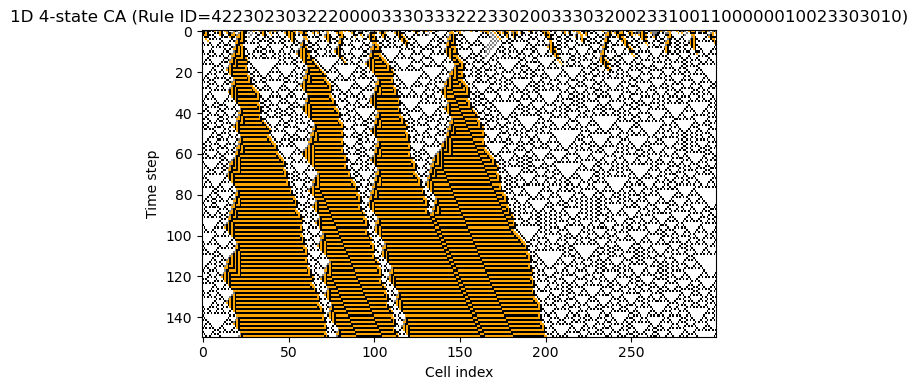

[Mutation 02] Rule ID = 42230230322200003330333222330200333032002331001110000010023303010


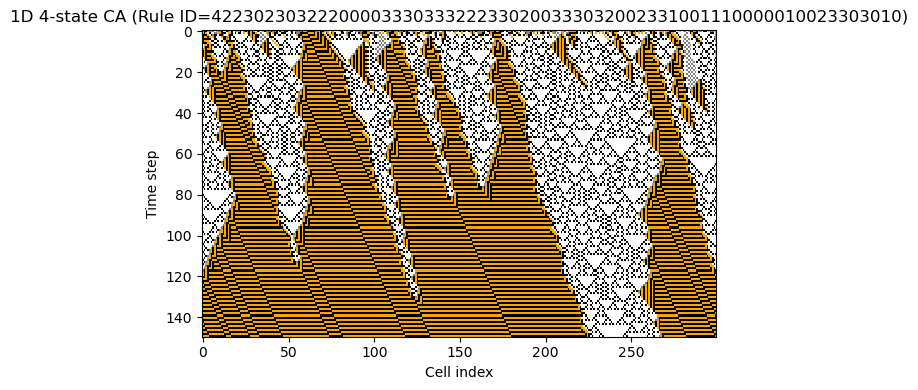

[Mutation 03] Rule ID = 42230230321200003330333222330200333032002331001100000010023303010


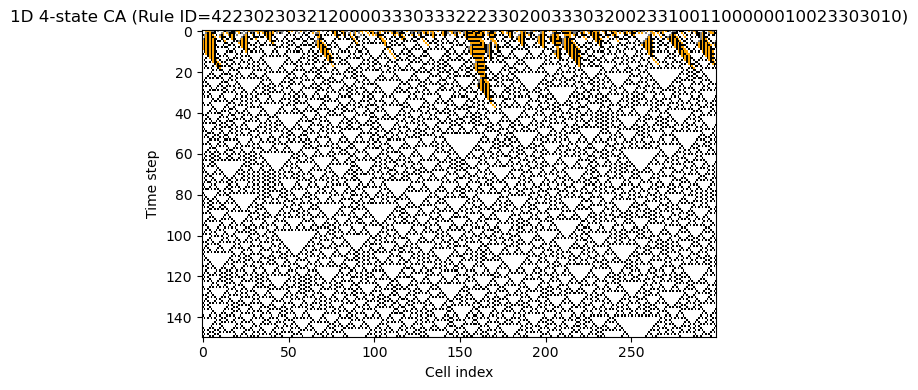

[Mutation 04] Rule ID = 42230230322200003330333222330200333032002331001110000010023303010


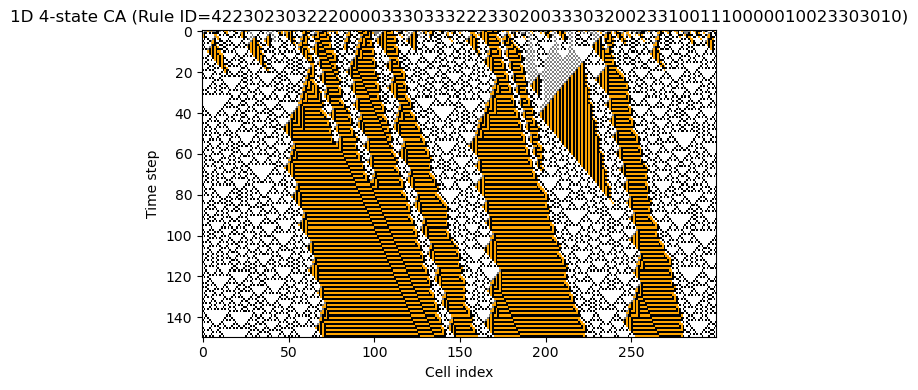

[Mutation 05] Rule ID = 42130230322200003330333222330200333032002331001100000010023303010


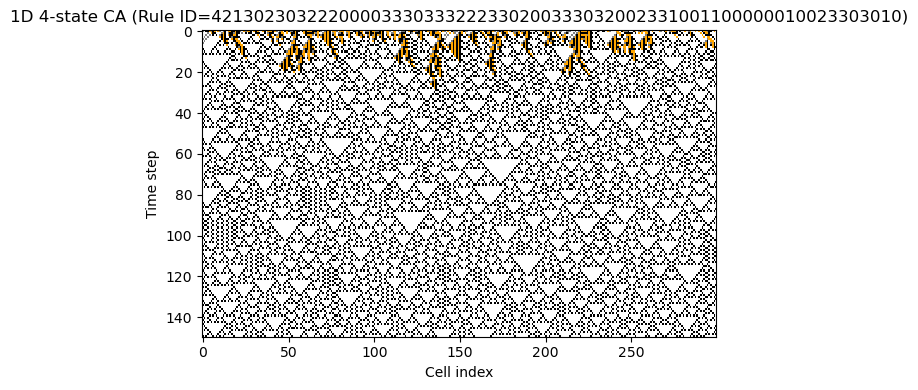

[Mutation 06] Rule ID = 42230230322200003330333222330200333032002331000100000010023303010


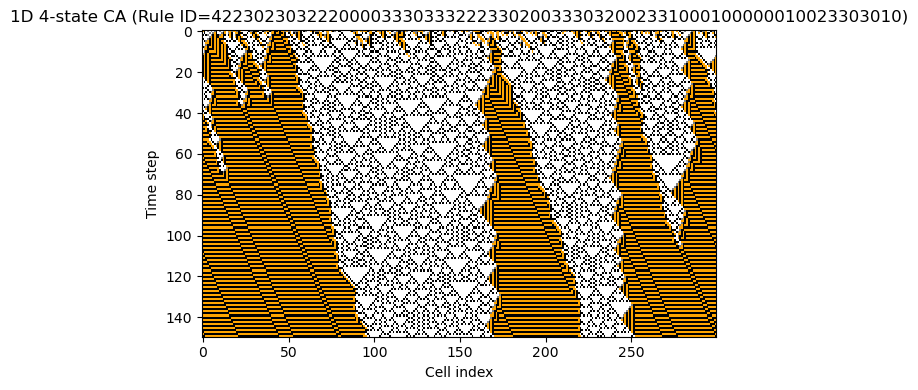

[Mutation 07] Rule ID = 42230230323200003330333222330200333032002331001100000010023303010


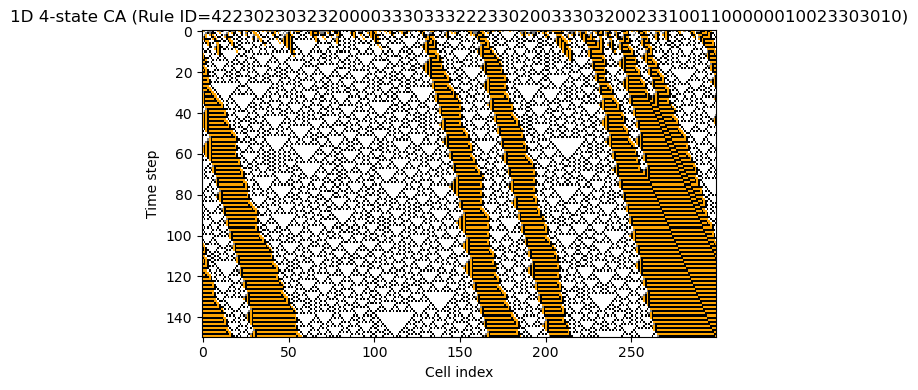

[Mutation 08] Rule ID = 42230130322200003330333222330200333032002331001100000010023303010


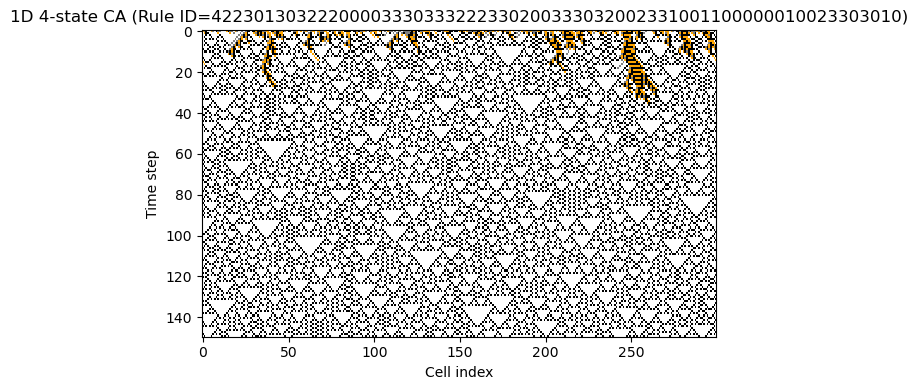

[Mutation 09] Rule ID = 42230230322200003330333322330200333032002331001100000010023303010


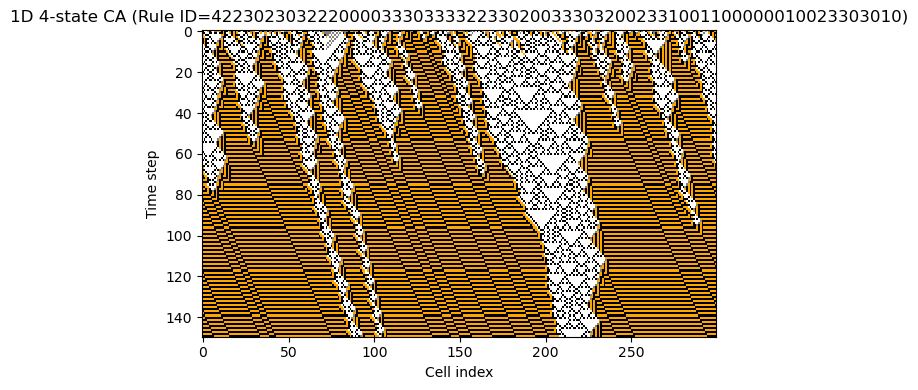

[Mutation 10] Rule ID = 42230230322200003330333222330200333032002331001100000010023303010


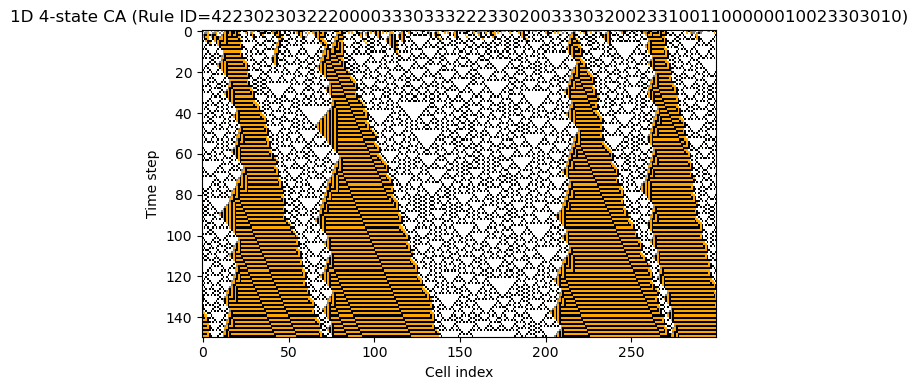

In [106]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from itertools import product
import random

class CellularAutomatonRules:
    """
    Creates, validates, executes, and visualizes 1D directional cellular automata
    with an explicit rule_id for a 4-state system.
    """
    def __init__(self, num_states, rule_id, stochastic=False, dim=1, directional=True):
        self.num_states   = num_states
        self.stochastic   = stochastic
        self.dim          = dim
        self.directional  = directional
        self.num_neighbors  = 3**dim - 1
        self.num_metastates = self.num_states ** (self.num_neighbors + 1)
        self.rule_id = None

        # prepare empty rules matrix
        self.rules_matrix = np.zeros((self.num_metastates, self.num_states - 1), dtype=int)
        # load the provided rule
        self.load_rule_id(rule_id)
        if not self.check_rules_matrix():
            raise ValueError("Rules matrix validation failed: some rows sum > 1.")

    def load_rule_id(self, rule_id):
        prefix = str(self.num_states)
        if not rule_id.startswith(prefix):
            raise ValueError("Rule ID num_states mismatch.")
        code = rule_id[len(prefix):]
        if len(code) != self.num_metastates:
            raise ValueError("Rule ID length does not match metastates.")
        self.rules_matrix.fill(0)
        for i, ch in enumerate(code):
            # interpret character in base-36 so 0–9 and A–Z both work
            digit = int(ch, 36)
            if digit < self.num_states - 1:
                self.rules_matrix[i, digit] = 1
        self.rule_id = rule_id

    def check_rules_matrix(self):
        row_sums = np.sum(self.rules_matrix, axis=1)
        invalid = np.where(row_sums > 1)[0]
        if invalid.size:
            for idx in invalid:
                print(f"Metastate {idx} sum > 1: {row_sums[idx]}")
            return False
        return True

    def _directional_metastate_tuples(self):
        return sorted(
            product(range(self.num_states), repeat=self.num_neighbors + 1),
            reverse=True
        )

    def run_1d(self, width, time_steps, init_mode='random', init_state=1, periodic=True):
        ca = np.zeros((time_steps, width), dtype=int)
        # initialize
        if init_mode == 'random':
            ca[0] = np.random.randint(0, self.num_states, size=width)
        elif init_mode == 'single':
            ca[0] = 0
            ca[0][width//2] = init_state
        elif init_mode == 'uniform':
            ca[0].fill(init_state)
        else:
            raise ValueError(f"Unknown init_mode: {init_mode}")

        # precompute neighborhood → index map
        tuples = self._directional_metastate_tuples()
        neigh_to_idx = {tpl: i for i, tpl in enumerate(tuples)}

        for t in range(1, time_steps):
            prev = ca[t-1]
            next_row = np.zeros(width, dtype=int)
            for i in range(width):
                left   = prev[(i-1)%width] if periodic else (prev[i-1] if i>0 else 0)
                center = prev[i]
                right  = prev[(i+1)%width] if periodic else (prev[i+1] if i<width-1 else 0)
                idx    = neigh_to_idx[(left, center, right)]
                row    = self.rules_matrix[idx]
                probs  = np.append(row, 1 - np.sum(row))
                if self.stochastic:
                    next_row[i] = np.random.choice(self.num_states, p=probs)
                else:
                    next_row[i] = int(np.argmax(probs))
            ca[t] = next_row
        return ca

    def plot_1d_spacetime(self, ca_array):
        cmap = mcolors.ListedColormap(['white','grey','orange','black'])
        plt.figure(figsize=(6, 4))
        plt.imshow(ca_array, aspect='auto', cmap=cmap, interpolation='nearest')
        plt.xlabel('Cell index')
        plt.ylabel('Time step')
        plt.title(f'1D 4-state CA (Rule ID={self.rule_id})')
        plt.tight_layout()
        plt.show()

def mutate_rule(rule_id, num_states=4):
    """
    Pick one position in rule_id (after the leading prefix),
    and increment or decrement that digit by 1 (clamped to [0, num_states-1]).
    """
    prefix = rule_id[0]
    code = list(rule_id[1:])
    pos = random.randrange(len(code))
    d = int(code[pos], 36)
    d_new = max(0, min(num_states-1, d + random.choice([-1, +1])))
    # convert back to char
    code[pos] = str(d_new) if d_new < 10 else chr(ord('A') + d_new - 10)
    return prefix + ''.join(code)

if __name__ == "__main__":
    # your original 4-state rule
    original_rule = "4" + "2230230322200003330333222330200333032002331001100000010023303010"

    for i in range(10):
        mutated = mutate_rule(original_rule, num_states=4)
        print(f"[Mutation {i+1:02d}] Rule ID = {mutated}")
        ca = CellularAutomatonRules(
            num_states=4,
            rule_id=mutated,
            stochastic=False,
            dim=1,
            directional=True
        )
        sim = ca.run_1d(width=300, time_steps=150, init_mode='random')
        ca.plot_1d_spacetime(sim)


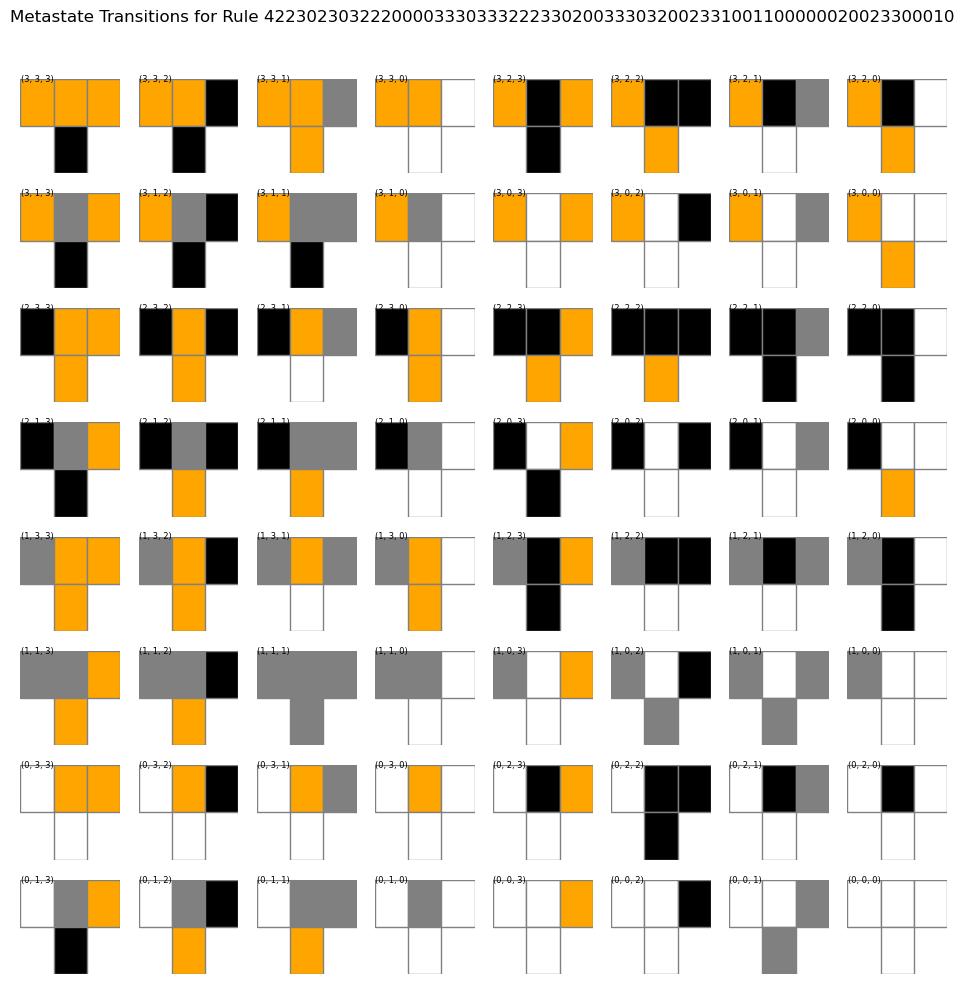

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from itertools import product
import numpy as np

def plot_metastate_diagrams(rule_id, num_states=4, cols=8):
    """
    rule_id: str, e.g. '4' + 64 digits/letters for a 4-state 1D CA
    num_states: number of states (default 4)
    cols: how many diagrams per row
    """
    # extract the code part and build a lookup of next-state
    code = rule_id[1:]
    # map neighborhood tuple → next-state
    # we sort neighborhoods in reverse lexical to match run_1d ordering
    neighborhoods = sorted(
        product(range(num_states), repeat=3),
        reverse=True
    )
    next_state = {
        nbr: int(code[i], 36)  # base-36 to int
        for i, nbr in enumerate(neighborhoods)
    }

    # color map for states 0,1,2,3
    cmap = ['white','grey','black','orange']

    total = len(neighborhoods)
    rows = (total + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.2, rows*1.2))
    axes = axes.flatten()

    for ax, nbr in zip(axes, neighborhoods):
        # draw the three input squares
        for j, state in enumerate(nbr):
            sq = mpatches.Rectangle((j, 1), 1, 1, facecolor=cmap[state], edgecolor='gray')
            ax.add_patch(sq)
        # draw the output square below
        out = next_state[nbr]
        sq = mpatches.Rectangle((1, 0), 1, 1, facecolor=cmap[out], edgecolor='gray')
        ax.add_patch(sq)

        ax.set_xlim(0, 3)
        ax.set_ylim(0, 2)
        ax.axis('off')
        # optional: label the input tuple
        ax.text(0.5, 1.9, str(nbr), ha='center', va='bottom', fontsize=6)

    # hide any extra subplots
    for ax in axes[total:]:
        ax.axis('off')

    plt.suptitle(f"Metastate Transitions for Rule {rule_id}", y=1.02)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # your 4-state rule ID
    rule_id = "4" + "2230230322200003330333222330200333032002331001100000020023300010"
    plot_metastate_diagrams(rule_id)


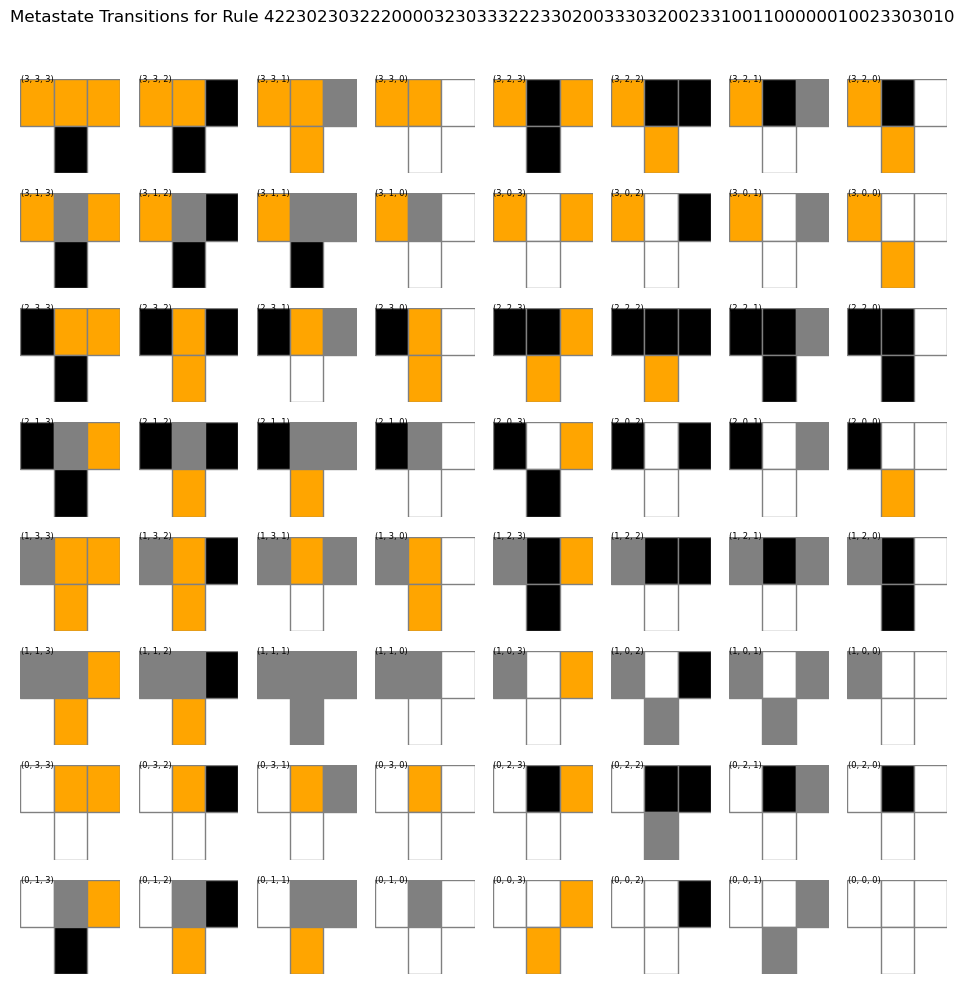

In [34]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from itertools import product
import numpy as np

def plot_metastate_diagrams(rule_id, num_states=4, cols=8):
    """
    rule_id: str, e.g. '4' + 64 digits/letters for a 4-state 1D CA
    num_states: number of states (default 4)
    cols: how many diagrams per row
    """
    # extract the code part and build a lookup of next-state
    code = rule_id[1:]
    # map neighborhood tuple → next-state
    # we sort neighborhoods in reverse lexical to match run_1d ordering
    neighborhoods = sorted(
        product(range(num_states), repeat=3),
        reverse=True
    )
    next_state = {
        nbr: int(code[i], 36)  # base-36 to int
        for i, nbr in enumerate(neighborhoods)
    }

    # color map for states 0,1,2,3
    cmap = ['white','grey','black','orange']

    total = len(neighborhoods)
    rows = (total + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.2, rows*1.2))
    axes = axes.flatten()

    for ax, nbr in zip(axes, neighborhoods):
        # draw the three input squares
        for j, state in enumerate(nbr):
            sq = mpatches.Rectangle((j, 1), 1, 1, facecolor=cmap[state], edgecolor='gray')
            ax.add_patch(sq)
        # draw the output square below
        out = next_state[nbr]
        sq = mpatches.Rectangle((1, 0), 1, 1, facecolor=cmap[out], edgecolor='gray')
        ax.add_patch(sq)

        ax.set_xlim(0, 3)
        ax.set_ylim(0, 2)
        ax.axis('off')
        # optional: label the input tuple
        ax.text(0.5, 1.9, str(nbr), ha='center', va='bottom', fontsize=6)

    # hide any extra subplots
    for ax in axes[total:]:
        ax.axis('off')

    plt.suptitle(f"Metastate Transitions for Rule {rule_id}", y=1.02)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # your 4-state rule ID
    rule_id = "4" + "2230230322200003230333222330200333032002331001100000010023303010"
    plot_metastate_diagrams(rule_id)


3 state

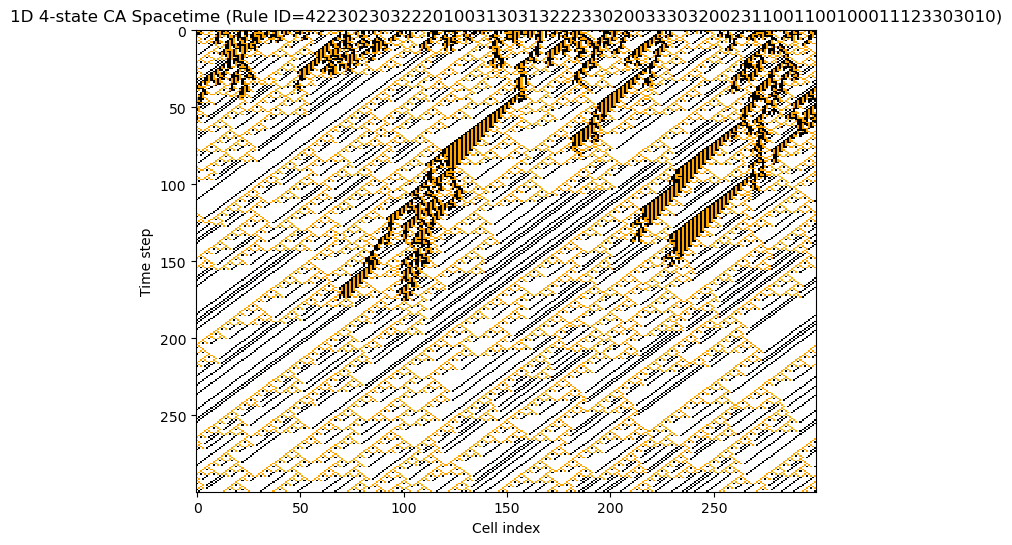

In [124]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from itertools import product

class CellularAutomatonRules:
    """
    Creates, validates, executes, and visualizes 1D directional cellular automata
    with an explicit rule_id for a 4-state system.
    """
    def __init__(self, num_states, rule_id, stochastic=False, dim=1, directional=True):
        self.num_states   = num_states
        self.stochastic   = stochastic
        self.dim          = dim
        self.directional  = directional
        self.num_neighbors  = 3**dim - 1
        self.num_metastates = self.num_states ** (self.num_neighbors + 1)
        self.rule_id = None

        # prepare empty rules matrix
        self.rules_matrix = np.zeros((self.num_metastates, self.num_states - 1), dtype=int)
        # load the provided rule
        self.load_rule_id(rule_id)
        if not self.check_rules_matrix():
            raise ValueError("Rules matrix validation failed: some rows sum > 1.")

    def load_rule_id(self, rule_id):
        prefix = str(self.num_states)
        if not rule_id.startswith(prefix):
            raise ValueError("Rule ID num_states mismatch.")
        code = rule_id[len(prefix):]
        if len(code) != self.num_metastates:
            raise ValueError("Rule ID length does not match metastates.")
        self.rules_matrix.fill(0)
        for i, ch in enumerate(code):
            digit = int(ch, 36)  # handles 0–9, A–Z if needed
            if digit < self.num_states - 1:
                self.rules_matrix[i, digit] = 1
        self.rule_id = rule_id

    def check_rules_matrix(self):
        row_sums = np.sum(self.rules_matrix, axis=1)
        invalid = np.where(row_sums > 1)[0]
        if invalid.size:
            for idx in invalid:
                print(f"Metastate {idx} sum > 1: {row_sums[idx]}")
            return False
        return True

    def _directional_metastate_tuples(self):
        return sorted(
            product(range(self.num_states), repeat=self.num_neighbors + 1),
            reverse=True
        )

    def run_1d(self, width, time_steps, init_mode='random', init_state=1, periodic=True):
        ca = np.zeros((time_steps, width), dtype=int)
        # initialize
        if init_mode == 'random':
            ca[0] = np.random.randint(0, self.num_states, size=width)
        elif init_mode == 'single':
            ca[0] = 0
            ca[0][width//2] = init_state
        elif init_mode == 'uniform':
            ca[0].fill(init_state)
        else:
            raise ValueError(f"Unknown init_mode: {init_mode}")

        # precompute neighborhood → index map
        tuples = self._directional_metastate_tuples()
        neigh_to_idx = {tpl: i for i, tpl in enumerate(tuples)}

        for t in range(1, time_steps):
            prev = ca[t-1]
            next_row = np.zeros(width, dtype=int)
            for i in range(width):
                left   = prev[(i-1)%width] if periodic else (prev[i-1] if i>0 else 0)
                center = prev[i]
                right  = prev[(i+1)%width] if periodic else (prev[i+1] if i<width-1 else 0)
                idx    = neigh_to_idx[(left, center, right)]
                row    = self.rules_matrix[idx]
                probs  = np.append(row, 1 - np.sum(row))
                if self.stochastic:
                    next_row[i] = np.random.choice(self.num_states, p=probs)
                else:
                    next_row[i] = int(np.argmax(probs))
            ca[t] = next_row
        return ca

    def plot_1d_spacetime(self, ca_array):
        cmap = mcolors.ListedColormap(['white','black','black','orange'])
        plt.figure(figsize=(8, 6))
        plt.imshow(ca_array, aspect='auto', cmap=cmap, interpolation='nearest')
        plt.xlabel('Cell index')
        plt.ylabel('Time step')
        plt.title(f'1D 4-state CA Spacetime (Rule ID={self.rule_id})')
        plt.show()


if __name__ == "__main__":
    # Your 4-state rule (prefix '4' + 64 characters)
    rule_id = "4" + "2230230322201003130313222330200333032002311001100100011123303010"
    ca = CellularAutomatonRules(
        num_states=4,
        rule_id=rule_id,
        stochastic=False,
        dim=1,
        directional=True
    )
    sim = ca.run_1d(width=300, time_steps=300, init_mode='random')
    ca.plot_1d_spacetime(sim)


[Mutation 01] Rule ID = 3111021102100212011101120210


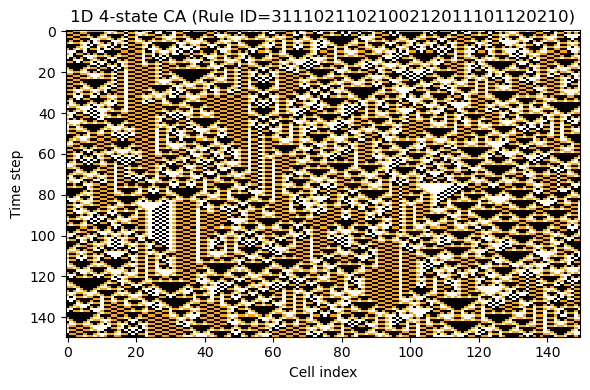

[Mutation 02] Rule ID = 3111021002100222011101120210


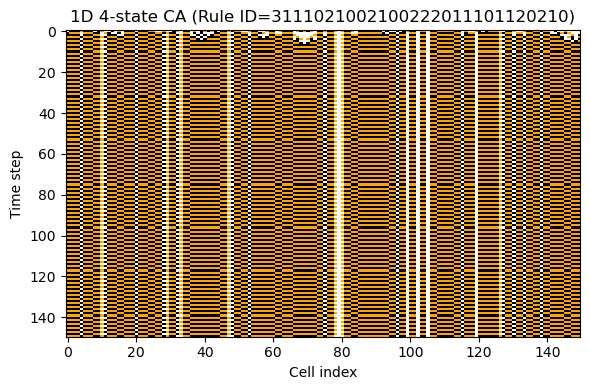

[Mutation 03] Rule ID = 3111011102100222011101120210


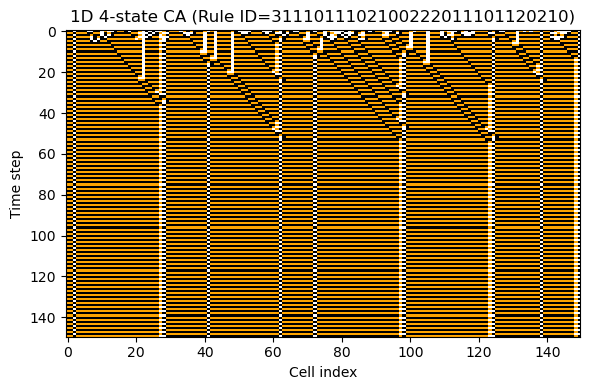

[Mutation 04] Rule ID = 3111021102100122011101120210


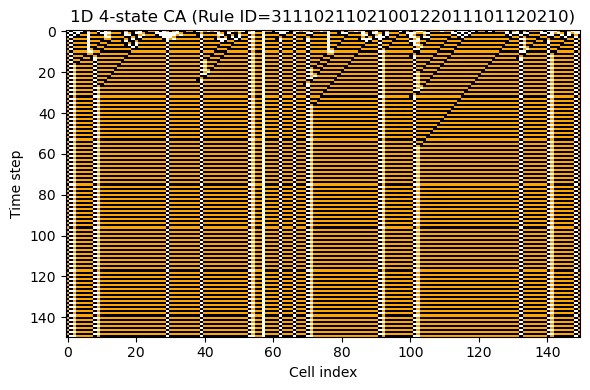

[Mutation 05] Rule ID = 3111021102100222011001120210


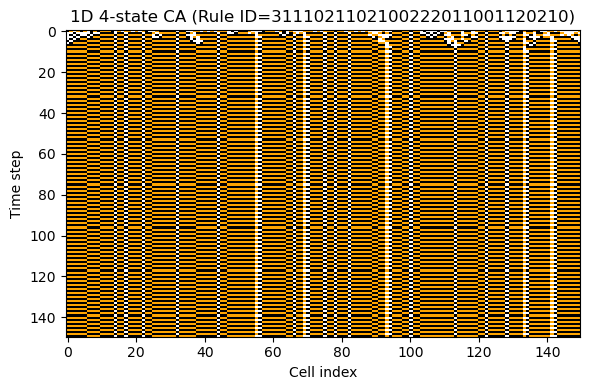

[Mutation 06] Rule ID = 3112021102100222011101120210


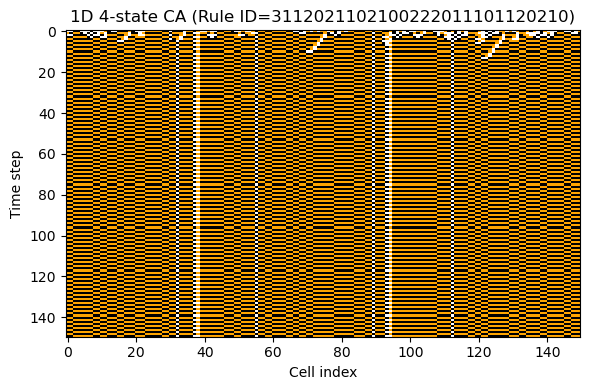

[Mutation 07] Rule ID = 3111021102100222011101120210


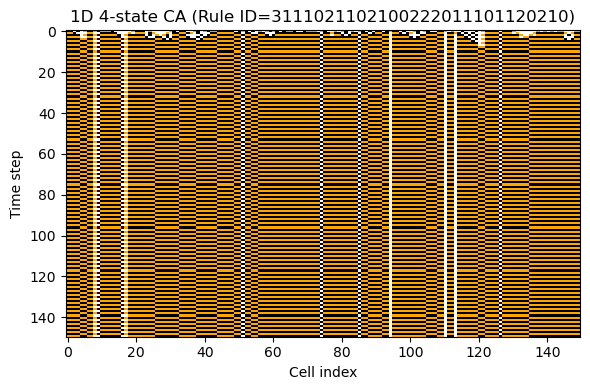

[Mutation 08] Rule ID = 3111021102100222011101120210


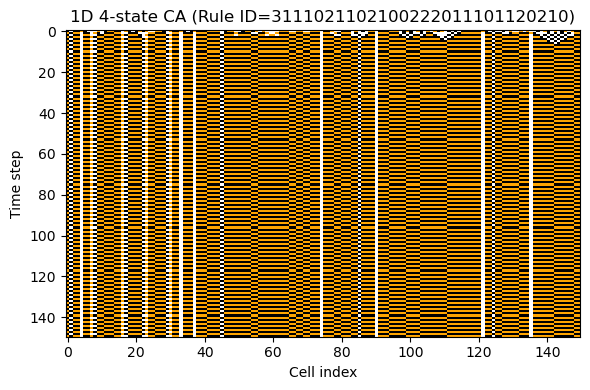

[Mutation 09] Rule ID = 3111021102100222011101020210


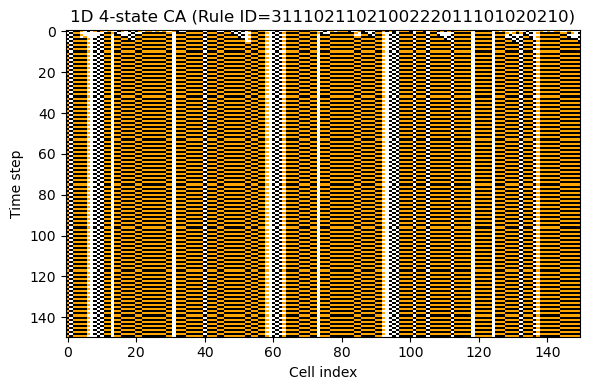

[Mutation 10] Rule ID = 3111021102100222011201120210


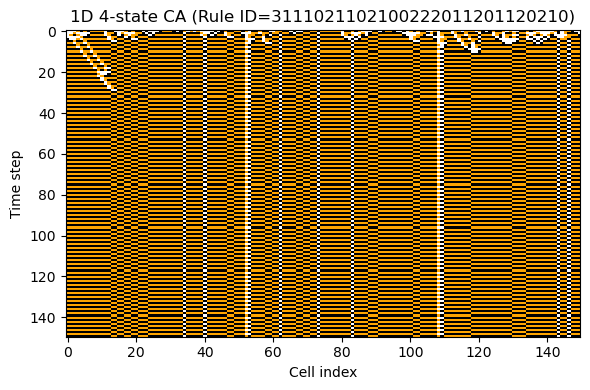

In [57]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from itertools import product
import random

class CellularAutomatonRules:
    """
    Creates, validates, executes, and visualizes 1D directional cellular automata
    with an explicit rule_id for a 4-state system.
    """
    def __init__(self, num_states, rule_id, stochastic=False, dim=1, directional=True):
        self.num_states   = num_states
        self.stochastic   = stochastic
        self.dim          = dim
        self.directional  = directional
        self.num_neighbors  = 3**dim - 1
        self.num_metastates = self.num_states ** (self.num_neighbors + 1)
        self.rule_id = None

        # prepare empty rules matrix
        self.rules_matrix = np.zeros((self.num_metastates, self.num_states - 1), dtype=int)
        # load the provided rule
        self.load_rule_id(rule_id)
        if not self.check_rules_matrix():
            raise ValueError("Rules matrix validation failed: some rows sum > 1.")

    def load_rule_id(self, rule_id):
        prefix = str(self.num_states)
        if not rule_id.startswith(prefix):
            raise ValueError("Rule ID num_states mismatch.")
        code = rule_id[len(prefix):]
        if len(code) != self.num_metastates:
            raise ValueError("Rule ID length does not match metastates.")
        self.rules_matrix.fill(0)
        for i, ch in enumerate(code):
            # interpret character in base-36 so 0–9 and A–Z both work
            digit = int(ch, 36)
            if digit < self.num_states - 1:
                self.rules_matrix[i, digit] = 1
        self.rule_id = rule_id

    def check_rules_matrix(self):
        row_sums = np.sum(self.rules_matrix, axis=1)
        invalid = np.where(row_sums > 1)[0]
        if invalid.size:
            for idx in invalid:
                print(f"Metastate {idx} sum > 1: {row_sums[idx]}")
            return False
        return True

    def _directional_metastate_tuples(self):
        return sorted(
            product(range(self.num_states), repeat=self.num_neighbors + 1),
            reverse=True
        )

    def run_1d(self, width, time_steps, init_mode='random', init_state=1, periodic=True):
        ca = np.zeros((time_steps, width), dtype=int)
        # initialize
        if init_mode == 'random':
            ca[0] = np.random.randint(0, self.num_states, size=width)
        elif init_mode == 'single':
            ca[0] = 0
            ca[0][width//2] = init_state
        elif init_mode == 'uniform':
            ca[0].fill(init_state)
        else:
            raise ValueError(f"Unknown init_mode: {init_mode}")

        # precompute neighborhood → index map
        tuples = self._directional_metastate_tuples()
        neigh_to_idx = {tpl: i for i, tpl in enumerate(tuples)}

        for t in range(1, time_steps):
            prev = ca[t-1]
            next_row = np.zeros(width, dtype=int)
            for i in range(width):
                left   = prev[(i-1)%width] if periodic else (prev[i-1] if i>0 else 0)
                center = prev[i]
                right  = prev[(i+1)%width] if periodic else (prev[i+1] if i<width-1 else 0)
                idx    = neigh_to_idx[(left, center, right)]
                row    = self.rules_matrix[idx]
                probs  = np.append(row, 1 - np.sum(row))
                if self.stochastic:
                    next_row[i] = np.random.choice(self.num_states, p=probs)
                else:
                    next_row[i] = int(np.argmax(probs))
            ca[t] = next_row
        return ca

    def plot_1d_spacetime(self, ca_array):
        cmap = mcolors.ListedColormap(['white','black','orange'])
        plt.figure(figsize=(6, 4))
        plt.imshow(ca_array, aspect='auto', cmap=cmap, interpolation='nearest')
        plt.xlabel('Cell index')
        plt.ylabel('Time step')
        plt.title(f'1D 4-state CA (Rule ID={self.rule_id})')
        plt.tight_layout()
        plt.show()

def mutate_rule(rule_id, num_states=4):
    """
    Pick one position in rule_id (after the leading prefix),
    and increment or decrement that digit by 1 (clamped to [0, num_states-1]).
    """
    prefix = rule_id[0]
    code = list(rule_id[1:])
    pos = random.randrange(len(code))
    d = int(code[pos], 36)
    d_new = max(0, min(num_states-1, d + random.choice([-1, +1])))
    # convert back to char
    code[pos] = str(d_new) if d_new < 10 else chr(ord('A') + d_new - 10)
    return prefix + ''.join(code)

if __name__ == "__main__":
    # your original 4-state rule
    original_rule = "3" + "111021102100222011101120210"

    for i in range(10):
        mutated = mutate_rule(original_rule, num_states=3)
        print(f"[Mutation {i+1:02d}] Rule ID = {mutated}")
        ca = CellularAutomatonRules(
            num_states=3,
            rule_id=mutated,
            stochastic=False,
            dim=1,
            directional=True
        )
        sim = ca.run_1d(width=150, time_steps=150, init_mode='random')
        ca.plot_1d_spacetime(sim)


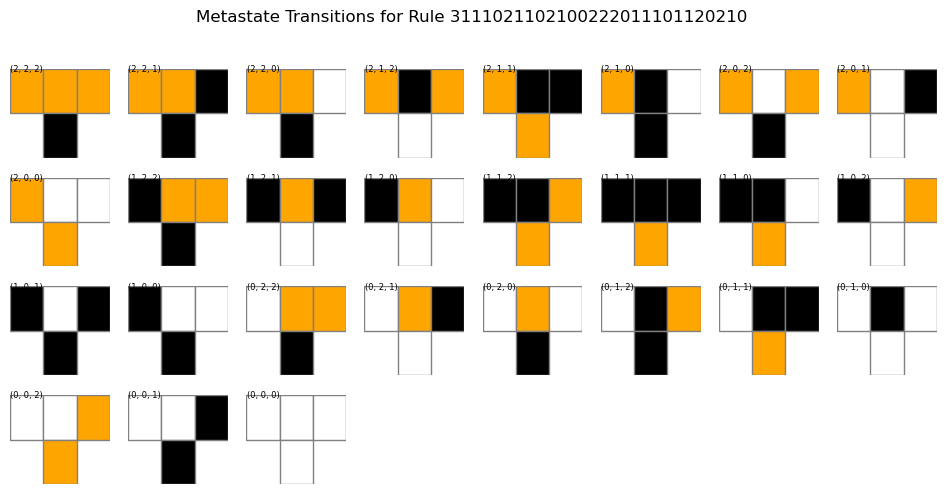

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from itertools import product
import numpy as np

def plot_metastate_diagrams(rule_id, num_states=3, cols=8):
    """
    rule_id: str, e.g. '4' + 64 digits/letters for a 4-state 1D CA
    num_states: number of states (default 4)
    cols: how many diagrams per row
    """
    # extract the code part and build a lookup of next-state
    code = rule_id[1:]
    # map neighborhood tuple → next-state
    # we sort neighborhoods in reverse lexical to match run_1d ordering
    neighborhoods = sorted(
        product(range(num_states), repeat=3),
        reverse=True
    )
    next_state = {
        nbr: int(code[i], 36)  # base-36 to int
        for i, nbr in enumerate(neighborhoods)
    }

    # color map for states 0,1,2,3
    cmap = ['white','black','orange']

    total = len(neighborhoods)
    rows = (total + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.2, rows*1.2))
    axes = axes.flatten()

    for ax, nbr in zip(axes, neighborhoods):
        # draw the three input squares
        for j, state in enumerate(nbr):
            sq = mpatches.Rectangle((j, 1), 1, 1, facecolor=cmap[state], edgecolor='gray')
            ax.add_patch(sq)
        # draw the output square below
        out = next_state[nbr]
        sq = mpatches.Rectangle((1, 0), 1, 1, facecolor=cmap[out], edgecolor='gray')
        ax.add_patch(sq)

        ax.set_xlim(0, 3)
        ax.set_ylim(0, 2)
        ax.axis('off')
        # optional: label the input tuple
        ax.text(0.5, 1.9, str(nbr), ha='center', va='bottom', fontsize=6)

    # hide any extra subplots
    for ax in axes[total:]:
        ax.axis('off')

    plt.suptitle(f"Metastate Transitions for Rule {rule_id}", y=1.02)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # your 4-state rule ID
    rule_id = "3" + "111021112100222111101120210"
    plot_metastate_diagrams(rule_id)


In [64]:
3111021102100212011101120210

3111021102100212011101120210

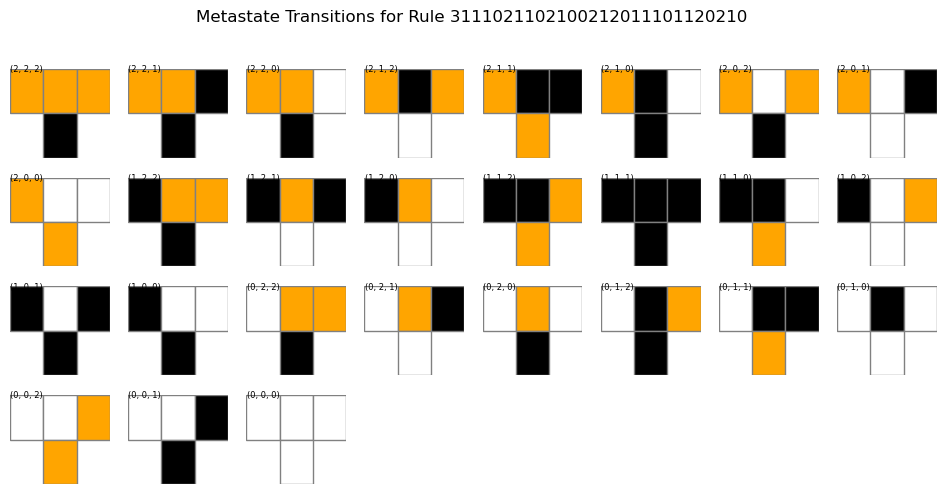

In [67]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from itertools import product
import numpy as np

def plot_metastate_diagrams(rule_id, num_states=3, cols=8):
    """
    rule_id: str, e.g. '4' + 64 digits/letters for a 4-state 1D CA
    num_states: number of states (default 4)
    cols: how many diagrams per row
    """
    # extract the code part and build a lookup of next-state
    code = rule_id[1:]
    # map neighborhood tuple → next-state
    # we sort neighborhoods in reverse lexical to match run_1d ordering
    neighborhoods = sorted(
        product(range(num_states), repeat=3),
        reverse=True
    )
    next_state = {
        nbr: int(code[i], 36)  # base-36 to int
        for i, nbr in enumerate(neighborhoods)
    }

    # color map for states 0,1,2,3
    cmap = ['white','black','orange']

    total = len(neighborhoods)
    rows = (total + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.2, rows*1.2))
    axes = axes.flatten()

    for ax, nbr in zip(axes, neighborhoods):
        # draw the three input squares
        for j, state in enumerate(nbr):
            sq = mpatches.Rectangle((j, 1), 1, 1, facecolor=cmap[state], edgecolor='gray')
            ax.add_patch(sq)
        # draw the output square below
        out = next_state[nbr]
        sq = mpatches.Rectangle((1, 0), 1, 1, facecolor=cmap[out], edgecolor='gray')
        ax.add_patch(sq)

        ax.set_xlim(0, 3)
        ax.set_ylim(0, 2)
        ax.axis('off')
        # optional: label the input tuple
        ax.text(0.5, 1.9, str(nbr), ha='center', va='bottom', fontsize=6)

    # hide any extra subplots
    for ax in axes[total:]:
        ax.axis('off')

    plt.suptitle(f"Metastate Transitions for Rule {rule_id}", y=1.02)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # your 4-state rule ID
    rule_id = "3" + "111021102100212011101120210"
    plot_metastate_diagrams(rule_id)


[Mutation 01] Rule ID = 3111021102100212011101120210


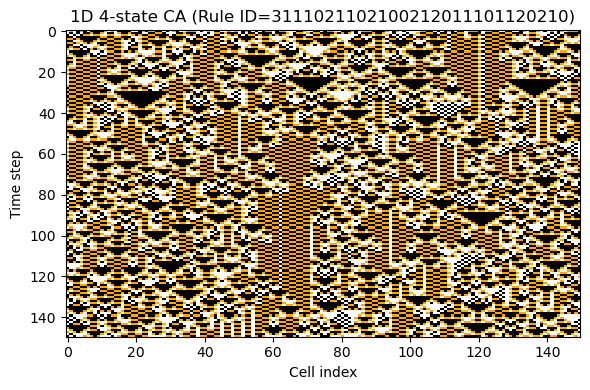

[Mutation 02] Rule ID = 3111021102000212011101120210


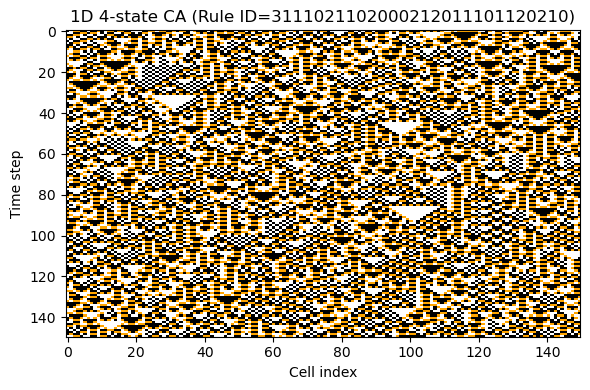

[Mutation 03] Rule ID = 3111021102100212011101110210


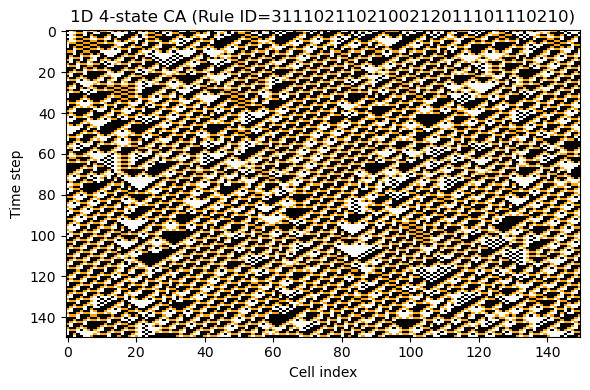

[Mutation 04] Rule ID = 3111021102100202011101120210


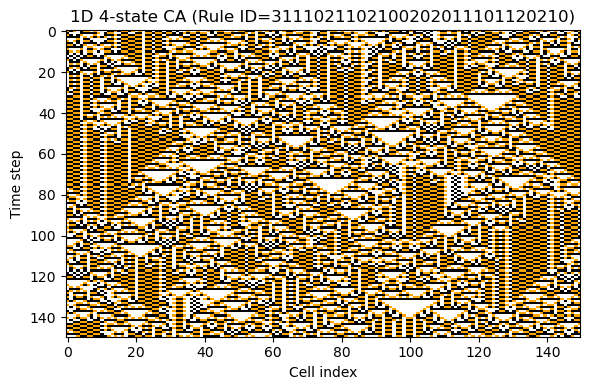

[Mutation 05] Rule ID = 3111021102100212012101120210


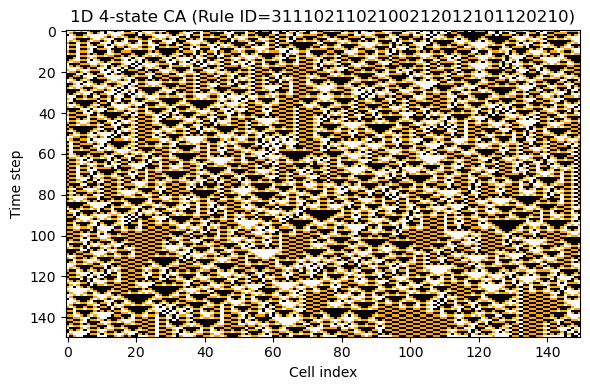

[Mutation 06] Rule ID = 3111021102100212011201120210


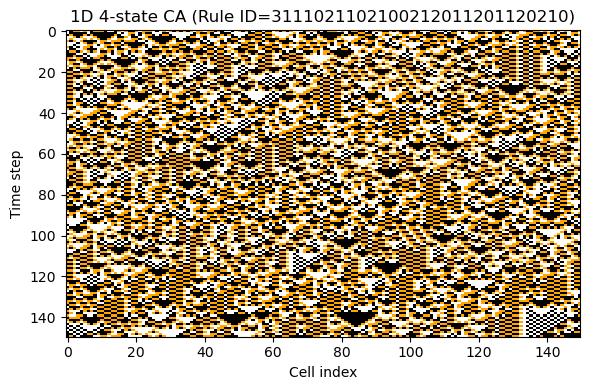

[Mutation 07] Rule ID = 3111021102100212011101120210


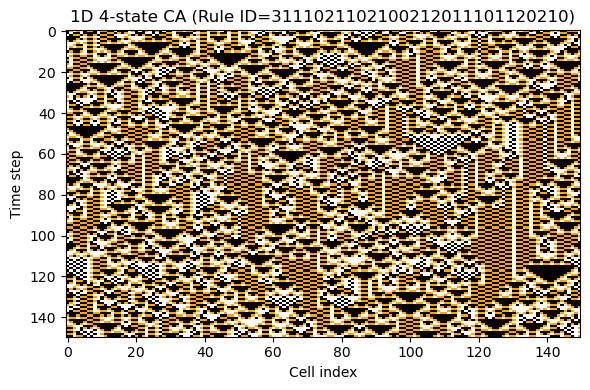

[Mutation 08] Rule ID = 3111021102100212011101120210


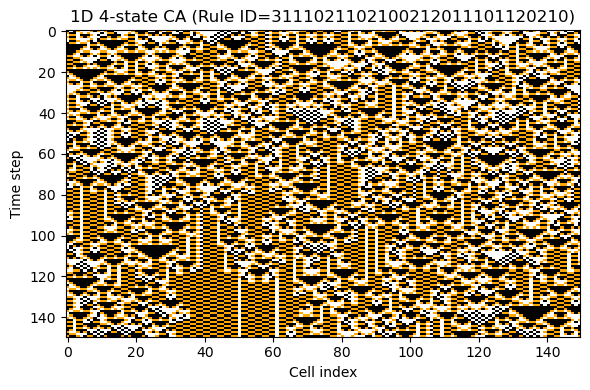

[Mutation 09] Rule ID = 3111021102100212111101120210


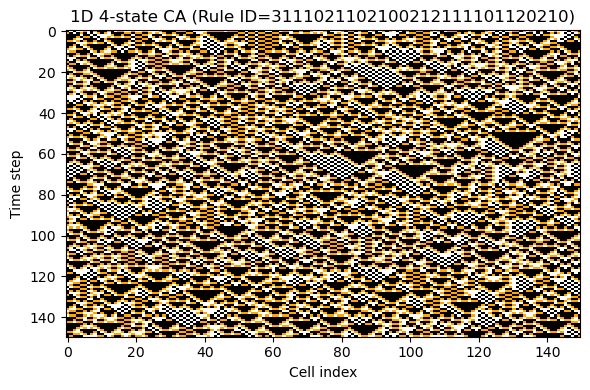

[Mutation 10] Rule ID = 3111021102100212011101220210


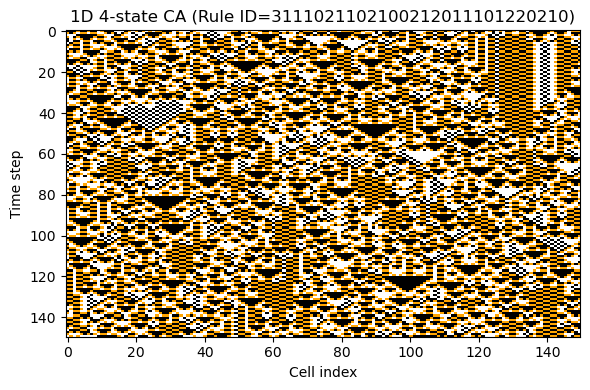

In [69]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from itertools import product
import random

class CellularAutomatonRules:
    """
    Creates, validates, executes, and visualizes 1D directional cellular automata
    with an explicit rule_id for a 4-state system.
    """
    def __init__(self, num_states, rule_id, stochastic=False, dim=1, directional=True):
        self.num_states   = num_states
        self.stochastic   = stochastic
        self.dim          = dim
        self.directional  = directional
        self.num_neighbors  = 3**dim - 1
        self.num_metastates = self.num_states ** (self.num_neighbors + 1)
        self.rule_id = None

        # prepare empty rules matrix
        self.rules_matrix = np.zeros((self.num_metastates, self.num_states - 1), dtype=int)
        # load the provided rule
        self.load_rule_id(rule_id)
        if not self.check_rules_matrix():
            raise ValueError("Rules matrix validation failed: some rows sum > 1.")

    def load_rule_id(self, rule_id):
        prefix = str(self.num_states)
        if not rule_id.startswith(prefix):
            raise ValueError("Rule ID num_states mismatch.")
        code = rule_id[len(prefix):]
        if len(code) != self.num_metastates:
            raise ValueError("Rule ID length does not match metastates.")
        self.rules_matrix.fill(0)
        for i, ch in enumerate(code):
            # interpret character in base-36 so 0–9 and A–Z both work
            digit = int(ch, 36)
            if digit < self.num_states - 1:
                self.rules_matrix[i, digit] = 1
        self.rule_id = rule_id

    def check_rules_matrix(self):
        row_sums = np.sum(self.rules_matrix, axis=1)
        invalid = np.where(row_sums > 1)[0]
        if invalid.size:
            for idx in invalid:
                print(f"Metastate {idx} sum > 1: {row_sums[idx]}")
            return False
        return True

    def _directional_metastate_tuples(self):
        return sorted(
            product(range(self.num_states), repeat=self.num_neighbors + 1),
            reverse=True
        )

    def run_1d(self, width, time_steps, init_mode='random', init_state=1, periodic=True):
        ca = np.zeros((time_steps, width), dtype=int)
        # initialize
        if init_mode == 'random':
            ca[0] = np.random.randint(0, self.num_states, size=width)
        elif init_mode == 'single':
            ca[0] = 0
            ca[0][width//2] = init_state
        elif init_mode == 'uniform':
            ca[0].fill(init_state)
        else:
            raise ValueError(f"Unknown init_mode: {init_mode}")

        # precompute neighborhood → index map
        tuples = self._directional_metastate_tuples()
        neigh_to_idx = {tpl: i for i, tpl in enumerate(tuples)}

        for t in range(1, time_steps):
            prev = ca[t-1]
            next_row = np.zeros(width, dtype=int)
            for i in range(width):
                left   = prev[(i-1)%width] if periodic else (prev[i-1] if i>0 else 0)
                center = prev[i]
                right  = prev[(i+1)%width] if periodic else (prev[i+1] if i<width-1 else 0)
                idx    = neigh_to_idx[(left, center, right)]
                row    = self.rules_matrix[idx]
                probs  = np.append(row, 1 - np.sum(row))
                if self.stochastic:
                    next_row[i] = np.random.choice(self.num_states, p=probs)
                else:
                    next_row[i] = int(np.argmax(probs))
            ca[t] = next_row
        return ca

    def plot_1d_spacetime(self, ca_array):
        cmap = mcolors.ListedColormap(['white','black','orange'])
        plt.figure(figsize=(6, 4))
        plt.imshow(ca_array, aspect='auto', cmap=cmap, interpolation='nearest')
        plt.xlabel('Cell index')
        plt.ylabel('Time step')
        plt.title(f'1D 4-state CA (Rule ID={self.rule_id})')
        plt.tight_layout()
        plt.show()

def mutate_rule(rule_id, num_states=4):
    """
    Pick one position in rule_id (after the leading prefix),
    and increment or decrement that digit by 1 (clamped to [0, num_states-1]).
    """
    prefix = rule_id[0]
    code = list(rule_id[1:])
    pos = random.randrange(len(code))
    d = int(code[pos], 36)
    d_new = max(0, min(num_states-1, d + random.choice([-1, +1])))
    # convert back to char
    code[pos] = str(d_new) if d_new < 10 else chr(ord('A') + d_new - 10)
    return prefix + ''.join(code)

if __name__ == "__main__":
    # your original 4-state rule
    original_rule = "3" + "111021102100212011101120210"

    for i in range(10):
        mutated = mutate_rule(original_rule, num_states=3)
        print(f"[Mutation {i+1:02d}] Rule ID = {mutated}")
        ca = CellularAutomatonRules(
            num_states=3,
            rule_id=mutated,
            stochastic=False,
            dim=1,
            directional=True
        )
        sim = ca.run_1d(width=150, time_steps=150, init_mode='random')
        ca.plot_1d_spacetime(sim)


In [70]:
3111021102100202011101120210

3111021102100202011101120210

[Mutation 01] Rule ID = 3111021102100202011101120210


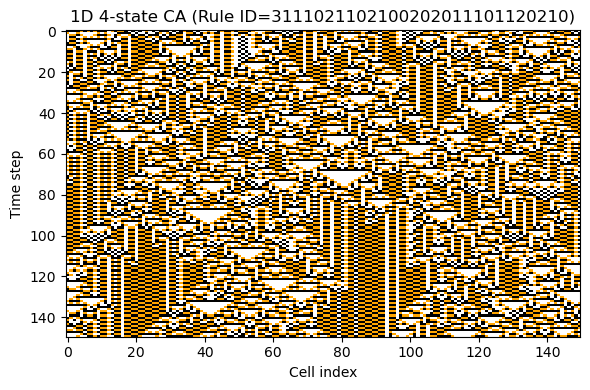

[Mutation 02] Rule ID = 3111021102100202011101120210


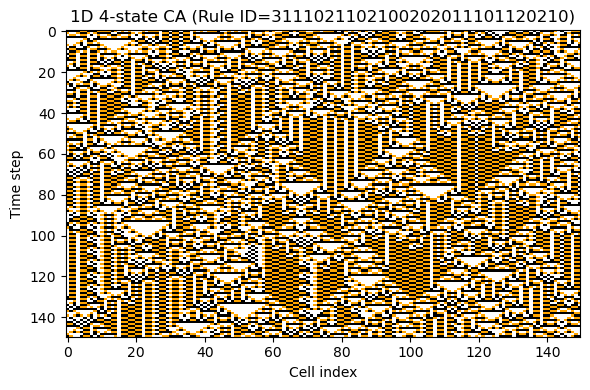

[Mutation 03] Rule ID = 3111021102100202011201120210


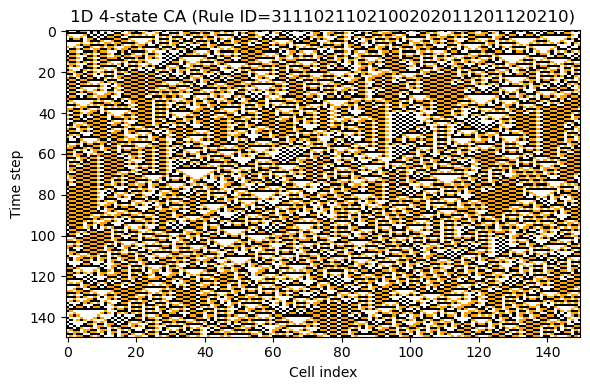

[Mutation 04] Rule ID = 3011021102100202011101120210


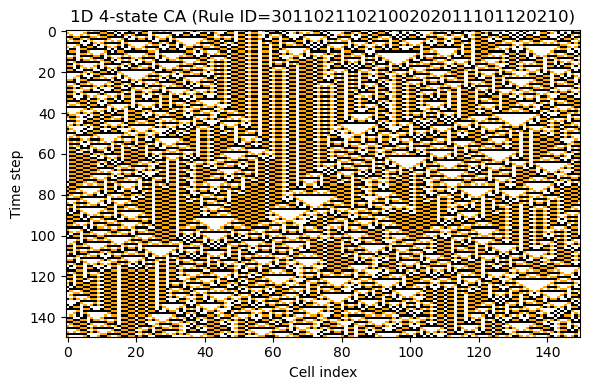

[Mutation 05] Rule ID = 3111021102100202011101220210


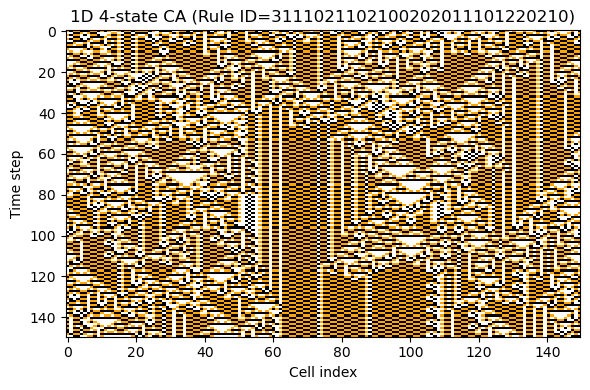

[Mutation 06] Rule ID = 3111021102100202011101120210


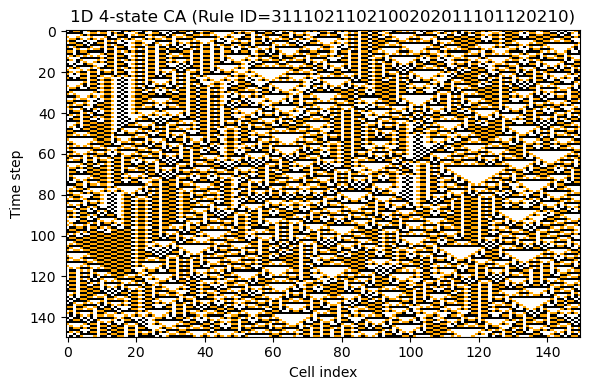

[Mutation 07] Rule ID = 3111021202100202011101120210


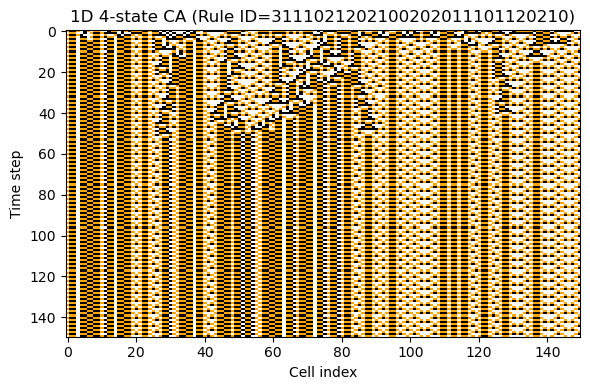

[Mutation 08] Rule ID = 3111021102100202021101120210


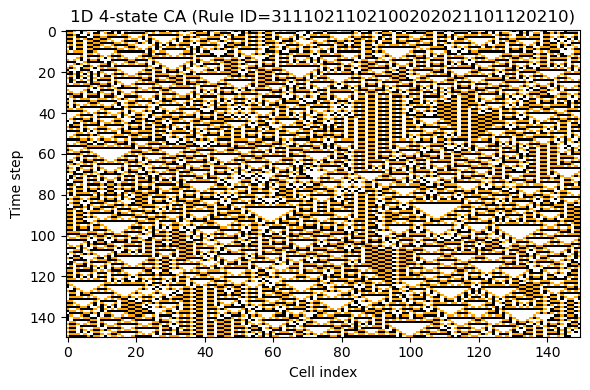

[Mutation 09] Rule ID = 3111021102100202011101120210


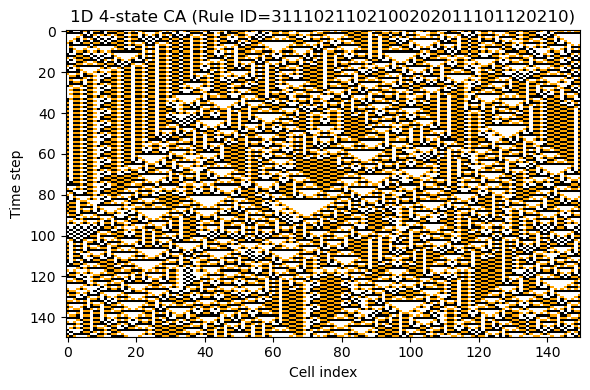

[Mutation 10] Rule ID = 3111021102100201011101120210


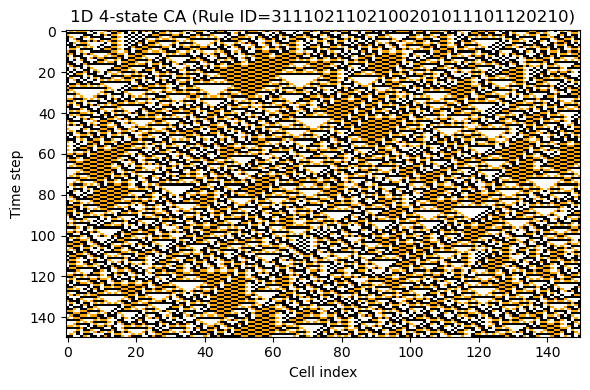

In [73]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from itertools import product
import random

class CellularAutomatonRules:
    """
    Creates, validates, executes, and visualizes 1D directional cellular automata
    with an explicit rule_id for a 4-state system.
    """
    def __init__(self, num_states, rule_id, stochastic=False, dim=1, directional=True):
        self.num_states   = num_states
        self.stochastic   = stochastic
        self.dim          = dim
        self.directional  = directional
        self.num_neighbors  = 3**dim - 1
        self.num_metastates = self.num_states ** (self.num_neighbors + 1)
        self.rule_id = None

        # prepare empty rules matrix
        self.rules_matrix = np.zeros((self.num_metastates, self.num_states - 1), dtype=int)
        # load the provided rule
        self.load_rule_id(rule_id)
        if not self.check_rules_matrix():
            raise ValueError("Rules matrix validation failed: some rows sum > 1.")

    def load_rule_id(self, rule_id):
        prefix = str(self.num_states)
        if not rule_id.startswith(prefix):
            raise ValueError("Rule ID num_states mismatch.")
        code = rule_id[len(prefix):]
        if len(code) != self.num_metastates:
            raise ValueError("Rule ID length does not match metastates.")
        self.rules_matrix.fill(0)
        for i, ch in enumerate(code):
            # interpret character in base-36 so 0–9 and A–Z both work
            digit = int(ch, 36)
            if digit < self.num_states - 1:
                self.rules_matrix[i, digit] = 1
        self.rule_id = rule_id

    def check_rules_matrix(self):
        row_sums = np.sum(self.rules_matrix, axis=1)
        invalid = np.where(row_sums > 1)[0]
        if invalid.size:
            for idx in invalid:
                print(f"Metastate {idx} sum > 1: {row_sums[idx]}")
            return False
        return True

    def _directional_metastate_tuples(self):
        return sorted(
            product(range(self.num_states), repeat=self.num_neighbors + 1),
            reverse=True
        )

    def run_1d(self, width, time_steps, init_mode='random', init_state=1, periodic=True):
        ca = np.zeros((time_steps, width), dtype=int)
        # initialize
        if init_mode == 'random':
            ca[0] = np.random.randint(0, self.num_states, size=width)
        elif init_mode == 'single':
            ca[0] = 0
            ca[0][width//2] = init_state
        elif init_mode == 'uniform':
            ca[0].fill(init_state)
        else:
            raise ValueError(f"Unknown init_mode: {init_mode}")

        # precompute neighborhood → index map
        tuples = self._directional_metastate_tuples()
        neigh_to_idx = {tpl: i for i, tpl in enumerate(tuples)}

        for t in range(1, time_steps):
            prev = ca[t-1]
            next_row = np.zeros(width, dtype=int)
            for i in range(width):
                left   = prev[(i-1)%width] if periodic else (prev[i-1] if i>0 else 0)
                center = prev[i]
                right  = prev[(i+1)%width] if periodic else (prev[i+1] if i<width-1 else 0)
                idx    = neigh_to_idx[(left, center, right)]
                row    = self.rules_matrix[idx]
                probs  = np.append(row, 1 - np.sum(row))
                if self.stochastic:
                    next_row[i] = np.random.choice(self.num_states, p=probs)
                else:
                    next_row[i] = int(np.argmax(probs))
            ca[t] = next_row
        return ca

    def plot_1d_spacetime(self, ca_array):
        cmap = mcolors.ListedColormap(['white','black','orange'])
        plt.figure(figsize=(6, 4))
        plt.imshow(ca_array, aspect='auto', cmap=cmap, interpolation='nearest')
        plt.xlabel('Cell index')
        plt.ylabel('Time step')
        plt.title(f'1D 4-state CA (Rule ID={self.rule_id})')
        plt.tight_layout()
        plt.show()

def mutate_rule(rule_id, num_states=4):
    """
    Pick one position in rule_id (after the leading prefix),
    and increment or decrement that digit by 1 (clamped to [0, num_states-1]).
    """
    prefix = rule_id[0]
    code = list(rule_id[1:])
    pos = random.randrange(len(code))
    d = int(code[pos], 36)
    d_new = max(0, min(num_states-1, d + random.choice([-1, +1])))
    # convert back to char
    code[pos] = str(d_new) if d_new < 10 else chr(ord('A') + d_new - 10)
    return prefix + ''.join(code)

if __name__ == "__main__":
    # your original 4-state rule
    original_rule = "3" + "111021102100202011101120210"

    for i in range(10):
        mutated = mutate_rule(original_rule, num_states=3)
        print(f"[Mutation {i+1:02d}] Rule ID = {mutated}")
        ca = CellularAutomatonRules(
            num_states=3,
            rule_id=mutated,
            stochastic=False,
            dim=1,
            directional=True
        )
        sim = ca.run_1d(width=150, time_steps=150, init_mode='random')
        ca.plot_1d_spacetime(sim)


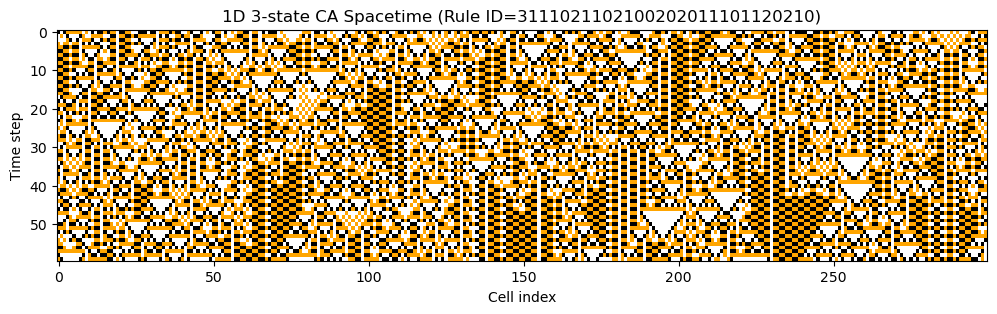

In [105]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from itertools import product

class CellularAutomatonRules:
    """
    Creates, validates, executes, and visualizes 1D directional cellular automata
    with an explicit rule_id for a 4-state system.
    """
    def __init__(self, num_states, rule_id, stochastic=False, dim=1, directional=True):
        self.num_states   = num_states
        self.stochastic   = stochastic
        self.dim          = dim
        self.directional  = directional
        self.num_neighbors  = 3**dim - 1
        self.num_metastates = self.num_states ** (self.num_neighbors + 1)
        self.rule_id = None

        # prepare empty rules matrix
        self.rules_matrix = np.zeros((self.num_metastates, self.num_states - 1), dtype=int)
        # load the provided rule
        self.load_rule_id(rule_id)
        if not self.check_rules_matrix():
            raise ValueError("Rules matrix validation failed: some rows sum > 1.")

    def load_rule_id(self, rule_id):
        prefix = str(self.num_states)
        if not rule_id.startswith(prefix):
            raise ValueError("Rule ID num_states mismatch.")
        code = rule_id[len(prefix):]
        if len(code) != self.num_metastates:
            raise ValueError("Rule ID length does not match metastates.")
        self.rules_matrix.fill(0)
        for i, ch in enumerate(code):
            digit = int(ch, 36)  # handles 0–9, A–Z if needed
            if digit < self.num_states - 1:
                self.rules_matrix[i, digit] = 1
        self.rule_id = rule_id

    def check_rules_matrix(self):
        row_sums = np.sum(self.rules_matrix, axis=1)
        invalid = np.where(row_sums > 1)[0]
        if invalid.size:
            for idx in invalid:
                print(f"Metastate {idx} sum > 1: {row_sums[idx]}")
            return False
        return True

    def _directional_metastate_tuples(self):
        return sorted(
            product(range(self.num_states), repeat=self.num_neighbors + 1),
            reverse=True
        )

    def run_1d(self, width, time_steps, init_mode='random', init_state=1, periodic=True):
        ca = np.zeros((time_steps, width), dtype=int)
        # initialize
        if init_mode == 'random':
            ca[0] = np.random.randint(0, self.num_states, size=width)
        elif init_mode == 'single':
            ca[0] = 0
            ca[0][width//2] = init_state
        elif init_mode == 'uniform':
            ca[0].fill(init_state)
        else:
            raise ValueError(f"Unknown init_mode: {init_mode}")

        # precompute neighborhood → index map
        tuples = self._directional_metastate_tuples()
        neigh_to_idx = {tpl: i for i, tpl in enumerate(tuples)}

        for t in range(1, time_steps):
            prev = ca[t-1]
            next_row = np.zeros(width, dtype=int)
            for i in range(width):
                left   = prev[(i-1)%width] if periodic else (prev[i-1] if i>0 else 0)
                center = prev[i]
                right  = prev[(i+1)%width] if periodic else (prev[i+1] if i<width-1 else 0)
                idx    = neigh_to_idx[(left, center, right)]
                row    = self.rules_matrix[idx]
                probs  = np.append(row, 1 - np.sum(row))
                if self.stochastic:
                    next_row[i] = np.random.choice(self.num_states, p=probs)
                else:
                    next_row[i] = int(np.argmax(probs))
            ca[t] = next_row
        return ca

    def plot_1d_spacetime(self, ca_array):
        cmap = mcolors.ListedColormap(['white','orange','black'])
        plt.figure(figsize=(12, 3))
        plt.imshow(ca_array, aspect='auto', cmap=cmap, interpolation='nearest')
        plt.xlabel('Cell index')
        plt.ylabel('Time step')
        plt.title(f'1D 3-state CA Spacetime (Rule ID={self.rule_id})')
        plt.show()


if __name__ == "__main__":
    # Your 4-state rule (prefix '4' + 64 characters)
    rule_id = "3" + "111021102100202011101120210"
    ca = CellularAutomatonRules(
        num_states=3,
        rule_id=rule_id,
        stochastic=False,
        dim=1,
        directional=True
    )
    sim = ca.run_1d(width= 300, time_steps=60, init_mode='random')
    ca.plot_1d_spacetime(sim)


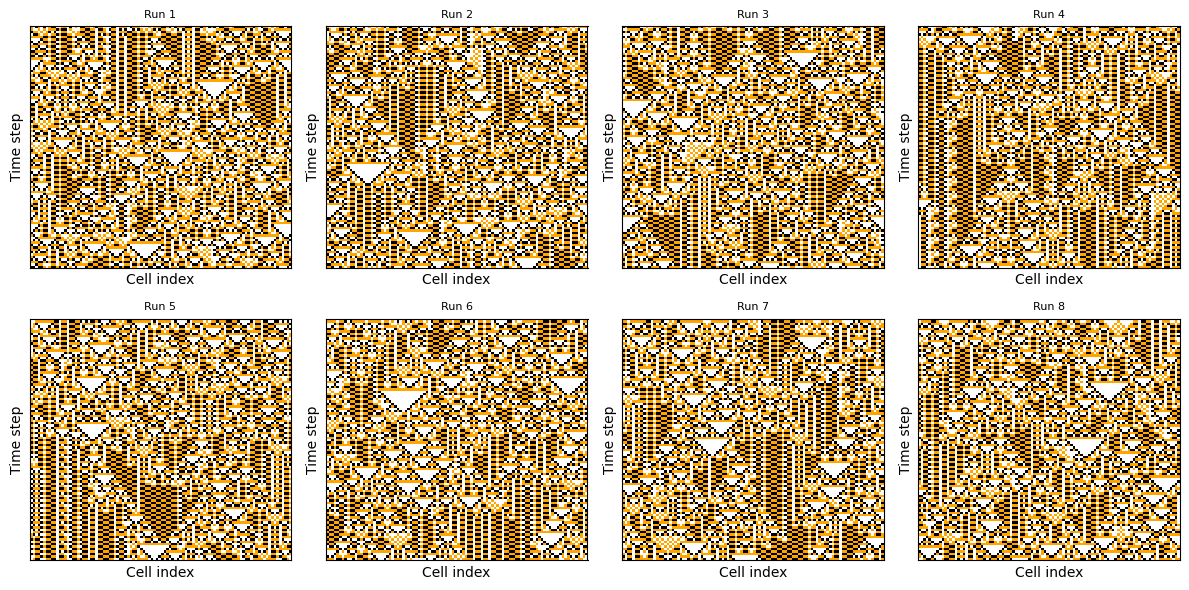

In [8]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from itertools import product

class CellularAutomatonRules:
    """
    Creates, validates, executes, and visualizes 1D directional cellular automata
    with an explicit rule_id for a 4-state system.
    """
    def __init__(self, num_states, rule_id, stochastic=False, dim=1, directional=True):
        self.num_states      = num_states
        self.stochastic      = stochastic
        self.dim             = dim
        self.directional     = directional
        self.num_neighbors   = 3**dim - 1
        self.num_metastates  = self.num_states ** (self.num_neighbors + 1)
        self.rule_id         = None

        # prepare empty rules matrix
        self.rules_matrix = np.zeros((self.num_metastates, self.num_states - 1), dtype=int)
        # load and validate
        self.load_rule_id(rule_id)
        if not self.check_rules_matrix():
            raise ValueError("Rules matrix validation failed: some rows sum > 1.")

    def load_rule_id(self, rule_id):
        prefix = str(self.num_states)
        if not rule_id.startswith(prefix):
            raise ValueError("Rule ID num_states mismatch.")
        code = rule_id[len(prefix):]
        if len(code) != self.num_metastates:
            raise ValueError("Rule ID length does not match metastates.")
        self.rules_matrix.fill(0)
        for i, ch in enumerate(code):
            digit = int(ch, 36)
            if digit < self.num_states - 1:
                self.rules_matrix[i, digit] = 1
        self.rule_id = rule_id

    def check_rules_matrix(self):
        row_sums = np.sum(self.rules_matrix, axis=1)
        invalid = np.where(row_sums > 1)[0]
        if invalid.size:
            for idx in invalid:
                print(f"Metastate {idx} sum > 1: {row_sums[idx]}")
            return False
        return True

    def _directional_metastate_tuples(self):
        return sorted(
            product(range(self.num_states), repeat=self.num_neighbors + 1),
            reverse=True
        )

    def run_1d(self, width, time_steps, init_mode='random', init_state=1, periodic=True):
        ca = np.zeros((time_steps, width), dtype=int)
        # initialize
        if init_mode == 'random':
            ca[0] = np.random.randint(0, self.num_states, size=width)
        elif init_mode == 'single':
            ca[0] = 0
            ca[0][width//2] = init_state
        elif init_mode == 'uniform':
            ca[0].fill(init_state)
        else:
            raise ValueError(f"Unknown init_mode: {init_mode}")

        tuples      = self._directional_metastate_tuples()
        neigh_to_idx = {tpl: i for i, tpl in enumerate(tuples)}

        for t in range(1, time_steps):
            prev     = ca[t-1]
            next_row = np.zeros(width, dtype=int)
            for i in range(width):
                left   = prev[(i-1)%width] if periodic else (prev[i-1] if i>0 else 0)
                center = prev[i]
                right  = prev[(i+1)%width] if periodic else (prev[i+1] if i<width-1 else 0)
                idx    = neigh_to_idx[(left, center, right)]
                row    = self.rules_matrix[idx]
                probs  = np.append(row, 1 - np.sum(row))
                if self.stochastic:
                    next_row[i] = np.random.choice(self.num_states, p=probs)
                else:
                    next_row[i] = int(np.argmax(probs))
            ca[t] = next_row

        return ca

    def plot_1d_spacetime(self, ca_array, ax=None):
        cmap = mcolors.ListedColormap(['white','orange','black'])
        if ax is None:
            plt.figure(figsize=(12, 3))
            ax = plt.gca()
        im = ax.imshow(ca_array, aspect='auto', cmap=cmap, interpolation='nearest')
        ax.set_xlabel('Cell index')
        ax.set_ylabel('Time step')
        ax.set_title(f'Run ({self.rule_id})')
        return im

    def plot_multiple_spacetime(self,
                                n_runs,
                                width,
                                time_steps,
                                init_mode='random',
                                ncols=4,
                                figsize_per_plot=(3, 3)):
        """
        Runs the CA `n_runs` times from random inits and
        lays out all spacetime images in one figure grid.
        """
        # compute layout
        nrows = math.ceil(n_runs / ncols)
        fig, axes = plt.subplots(
            nrows, ncols,
            figsize=(figsize_per_plot[0]*ncols,
                     figsize_per_plot[1]*nrows),
            squeeze=False
        )

        # generate & plot each run
        run_idx = 0
        for r in range(nrows):
            for c in range(ncols):
                ax = axes[r][c]
                if run_idx < n_runs:
                    sim = self.run_1d(width, time_steps, init_mode=init_mode)
                    self.plot_1d_spacetime(sim, ax=ax)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    ax.set_title(f'Run {run_idx+1}', fontsize=8)
                else:
                    ax.axis('off')
                run_idx += 1

        # plt.suptitle(f'{n_runs} runs of 1D {self.num_states}-state CA (Rule {self.rule_id})',
        #              y=1.02)
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    # example 3‐state rule_id
    rule_id = "3" + "111021102100202011101120210"
    # rule_id = "3" + "111021112100212111101120210"
    # rule_id = "3" + "111021122100202211101120210"
    # rule_id = "3" + "111021122100202201101121210"
    ca = CellularAutomatonRules(
        num_states=3,
        rule_id=rule_id,
        stochastic=False,
        dim=1,
        directional=True
    )

    # plot 8 independent runs in a 2×4 grid
    ca.plot_multiple_spacetime(
        n_runs=8,
        width=100,
        time_steps=100,
        init_mode='random',
        ncols=4,
        figsize_per_plot=(3,3)
    )

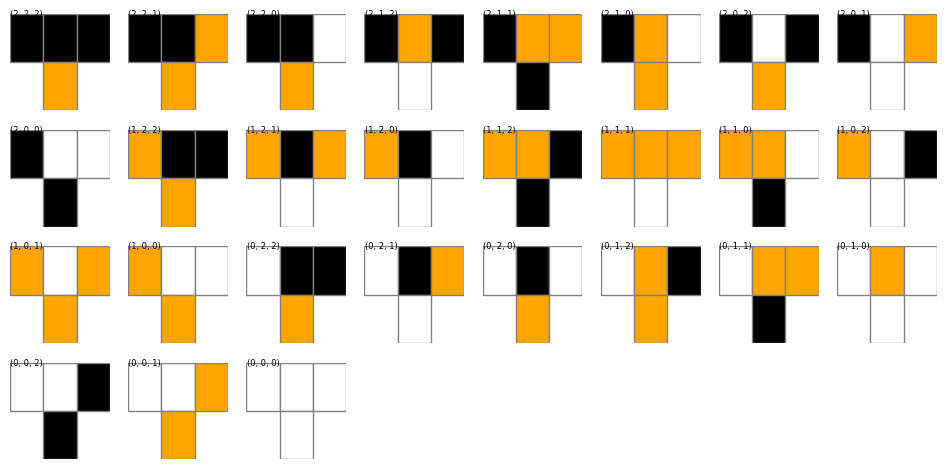

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from itertools import product
import numpy as np

def plot_metastate_diagrams(rule_id, num_states=3, cols=8):
    """
    rule_id: str, e.g. '4' + 64 digits/letters for a 4-state 1D CA
    num_states: number of states (default 4)
    cols: how many diagrams per row
    """
    # extract the code part and build a lookup of next-state
    code = rule_id[1:]
    # map neighborhood tuple → next-state
    # we sort neighborhoods in reverse lexical to match run_1d ordering
    neighborhoods = sorted(
        product(range(num_states), repeat=3),
        reverse=True
    )
    next_state = {
        nbr: int(code[i], 36)  # base-36 to int
        for i, nbr in enumerate(neighborhoods)
    }

    # color map for states 0,1,2,3
    cmap = ['white','orange','black']

    total = len(neighborhoods)
    rows = (total + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.2, rows*1.2))
    axes = axes.flatten()

    for ax, nbr in zip(axes, neighborhoods):
        # draw the three input squares
        for j, state in enumerate(nbr):
            sq = mpatches.Rectangle((j, 1), 1, 1, facecolor=cmap[state], edgecolor='gray')
            ax.add_patch(sq)
        # draw the output square below
        out = next_state[nbr]
        sq = mpatches.Rectangle((1, 0), 1, 1, facecolor=cmap[out], edgecolor='gray')
        ax.add_patch(sq)

        ax.set_xlim(0, 3)
        ax.set_ylim(0, 2)
        ax.axis('off')
        # optional: label the input tuple
        ax.text(0.5, 1.9, str(nbr), ha='center', va='bottom', fontsize=6)

    # hide any extra subplots
    for ax in axes[total:]:
        ax.axis('off')

    # plt.suptitle(f"Metastate Transitions for Rule {rule_id}", y=1.02)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # your 4-state rule ID
    rule_id = "3" + "111021102100202011101120210"
    # rule_id = "3" + "111021122100202201101121210"
    plot_metastate_diagrams(rule_id)


18 [-0.23725252 -0.35754226]
19 [-0.60474796 -0.67085325]
20 [ 0.01562799 -0.30181408]
21 [-0.34651387  0.94473458]
22 [-0.27312082  0.36876563]
23 [ 0.86601086 -0.30263381]
16 [ 0.96906    -0.79381847]
17 [ 0.2785598  -0.83316324]
12 [-0.68999331 -0.40527378]
13 [-0.77091288 -0.39294541]
14 [-0.8125733  -0.12924774]
15 [-0.83173409 -0.3799307 ]
0 [ 0.45612526 -0.03302318]
1 [-0.28514092 -0.37650512]
2 [-0.91615134 -0.96370917]
3 [0.39011075 0.13122329]
24 [-0.72284575  0.67583801]
25 [ 0.21833038 -0.77318183]
26 [-0.09415142  0.08664184]
9 [ 0.65648102 -0.91785162]
10 [-0.00882883 -0.04232827]
11 [ 0.82505346 -0.30345736]
7 [-0.51201244 -0.00572421]
8 [ 0.8137438  -0.02986851]
4 [-0.37454018  0.25958672]
5 [-0.50898835  0.28311663]
6 [-0.46310389  0.90461775]


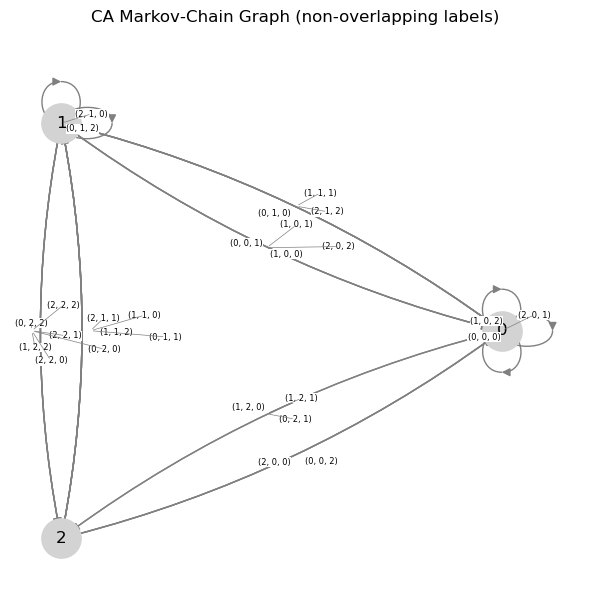

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import product
from adjustText import adjust_text

def build_ca_markov_graph(rule_id: str, num_states: int = 3) -> nx.MultiDiGraph:
    code = rule_id[1:]
    neighborhoods = sorted(product(range(num_states), repeat=3), reverse=True)
    next_state = {
        nbr: int(code[i], 36)
        for i, nbr in enumerate(neighborhoods)
    }
    G = nx.MultiDiGraph()
    G.add_nodes_from(range(num_states))
    # store each triple as its own edge so we can label separately
    for nbr in neighborhoods:
        center = nbr[1]
        out    = next_state[nbr]
        G.add_edge(center, out, label=str(nbr))
    return G

def plot_ca_markov_graph(
    G: nx.MultiDiGraph,
    figsize=(6,6),
    tuple_label_font_size: int = 6,
    offset_distance: float = 0.1
):
    """
    Draws the CA Markov graph with non‐overlapping edge‐labels.
    - offset_distance: how far (in data‐coords) to push label off the edge
    """
    pos = nx.circular_layout(G)
    fig, ax = plt.subplots(figsize=figsize)

    # 1) draw nodes
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='lightgray', node_size=800)
    nx.draw_networkx_labels  (G, pos, ax=ax, font_size=12)

    # 2) draw all edges with a small uniform curvature
    nx.draw_networkx_edges(
        G, pos, ax=ax,
        arrowstyle='-|>',
        arrowsize=12,
        connectionstyle='arc3,rad=0.1',
        edge_color='gray'
    )

    # 3) collect text objects for adjustText
    texts = []
    # we'll position each label at the midpoint, then offset perpendicular
    for u, v, data in G.edges(data=True):
        label = data['label']
        x1, y1 = pos[u]
        x2, y2 = pos[v]
        # midpoint
        mx, my = (x1 + x2)/2, (y1 + y2)/2
        # perpendicular vector
        dx, dy = x2 - x1, y2 - y1
        ox, oy = -dy, dx
        norm = (ox**2 + oy**2)**0.5
        if norm != 0:
            ox, oy = (ox/norm)*offset_distance, (oy/norm)*offset_distance
        # draw the text with a white bbox
        txt = ax.text(
            mx + ox, my + oy, label,
            fontsize=tuple_label_font_size,
            ha='center', va='center',
            bbox=dict(facecolor='white', edgecolor='none', pad=0.3)
        )
        texts.append(txt)

    # 4) adjust to remove overlaps, enforcing a little extra padding
    adjust_text(
        texts, ax=ax,
        expand_text=(1.2,1.2),
        expand_points=(1.2,1.2),
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.5)
    )

    ax.set_axis_off()
    plt.title("CA Markov‐Chain Graph (non‐overlapping labels)", y=1.05)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # example 3‐state rule_id
    rule_id = "3" + "111021102100202011101120210"
    G = build_ca_markov_graph(rule_id, num_states=3)
    plot_ca_markov_graph(G, tuple_label_font_size=6, offset_distance=0.1)